#Building an OCR system for Hindi

##Mounting Drive [for saving]

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Create Train and Test Sets

In [0]:
from pathlib import Path


test_path = '/content/gdrive/My Drive/validation'
data_path = '/content/gdrive/My Drive/characters'

def create_sets(data_path, out_path, train_ratio):
  
    dir_paths = [child for child in Path(data_path).iterdir() if child.is_dir()]
    for i, dir_path in enumerate(dir_paths):
        
        files = list(dir_path.iterdir())
        train_len = int(len(files) * (1 - train_ratio)) 

        
        out_dir = Path(out_path).joinpath(dir_path.name)
        if not out_dir.exists():
            out_dir.mkdir(parents=True)

        
        for file_ in files[:train_len]:
            file_.replace(out_dir.joinpath(file_.name))

#Run once to create the data folders in drive, or elsewhere

#Creates test data set, rest left behind in characters to form the train dataset

#create_sets(data_path, test_path, 0.7)

##Image Pre-processing

####Image Thresholding and Deskewing [Gaussian Filter + Otsu]

(665, 600)
[INFO] angle: -0.000


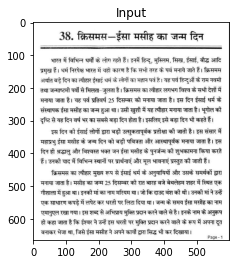

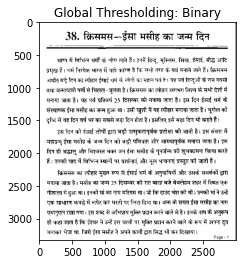

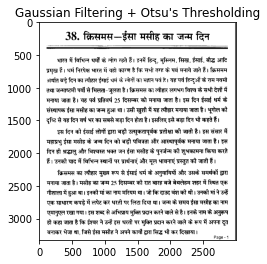

In [0]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread('/content/gdrive/My Drive/test3.jpg',0)

plt.imshow(img,'gray')

print(img.shape)
scale_percent = 500 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

#Converting to B&W

if len(img.shape) == 3:
	gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
	img = cv.bitwise_not(gray)


#Thresholding

thresh = cv.threshold(img, 0, 255,
	cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

#Deskewing

coords = np.column_stack(np.where(thresh > 0))
angle = cv.minAreaRect(coords)[-1]

if angle < -45:
	angle = -(90 + angle)
else:
	angle = -angle


(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, angle, 1.0)
rotated = cv.warpAffine(img, M, (w, h),
	flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

# show the rotated output image
print("[INFO] angle: {:.3f}".format(angle))
plt.imshow(img, 'gray')
plt.title("Input")
plt.show()

rimg = cv.resize(rotated, dim, interpolation = cv.INTER_AREA)

ret,thresh1 = cv.threshold(rimg,127,255,cv.THRESH_BINARY)

plt.imshow(thresh1,'gray')
plt.title("Global Thresholding: Binary")
plt.show()

blur = cv.GaussianBlur(rimg,(5,5),0)
ret3,final_image = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

plt.imshow(final_image,'gray')
plt.title("Gaussian Filtering + Otsu's Thresholding")
plt.show()

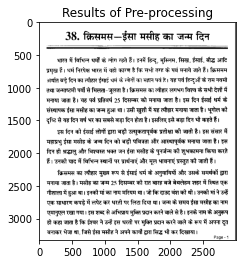

(3325, 3000)


In [0]:
plt.imshow(final_image, 'gray')
plt.title('Results of Pre-processing')
plt.show()

print(final_image.shape)

###Line Segmentation

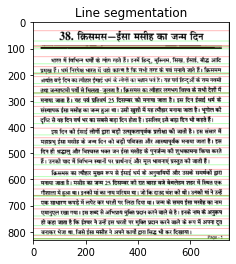

In [0]:
#resize back to original shape

scale_percent = 25 # percent of original size
width = int(final_image.shape[1] * scale_percent / 100)
height = int(final_image.shape[0] * scale_percent / 100)
dim2 = (width, height)

rfinal_image = cv.resize(final_image, dim2, interpolation = cv.INTER_AREA)



ret4, inverse = cv.threshold(rfinal_image, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
pts = cv.findNonZero(inverse)
ret = cv.minAreaRect(pts)

(cx,cy), (w,h), ang = ret
if w>h:
    w,h = h,w
    ang += 0

## (4) Find rotated matrix, do rotation
#M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
#rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

## (5) find and draw the upper and lower boundary of each lines
rotated = inverse
hist = cv.reduce(inverse,1, cv.REDUCE_AVG).reshape(-1)

th = 2
H,W = inverse.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

inverse = cv.cvtColor(rotated, cv.COLOR_GRAY2BGR)
ret5, segmented = cv.threshold(inverse, 127, 255, cv.THRESH_BINARY_INV)
for y in uppers:
    cv.line(segmented, (0,y), (W, y), (255,0,0), 1)

for y in lowers:
    cv.line(segmented, (0,y), (W, y), (0,255,0), 1)

plt.imshow(segmented, 'gray')
plt.title("Line segmentation")
plt.show()

In [0]:
uppers,lowers

([33,
  89,
  95,
  132,
  170,
  196,
  208,
  245,
  270,
  284,
  321,
  359,
  404,
  441,
  479,
  517,
  561,
  599,
  636,
  661,
  674,
  712,
  750,
  787,
  814,
  826],
 [72,
  92,
  102,
  159,
  193,
  198,
  234,
  269,
  273,
  307,
  349,
  387,
  430,
  469,
  506,
  544,
  589,
  621,
  660,
  664,
  699,
  739,
  776,
  811,
  825,
  827])

###Word Segmentation

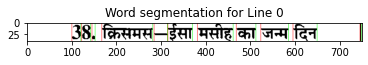

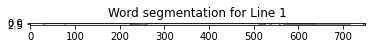

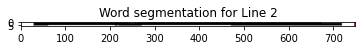

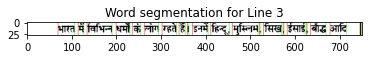

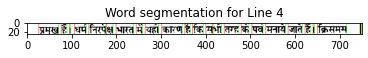

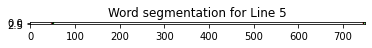

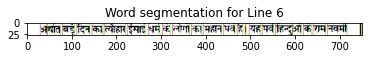

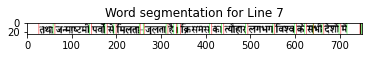

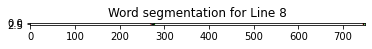

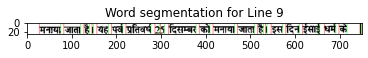

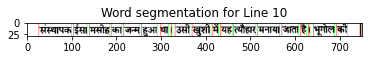

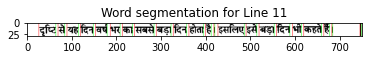

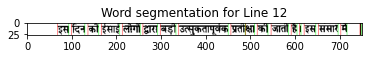

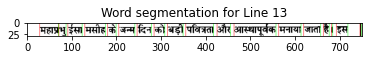

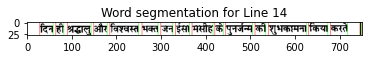

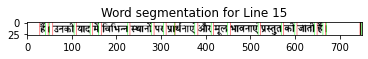

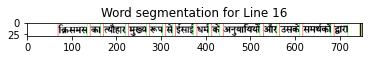

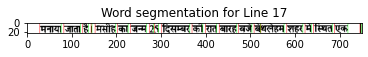

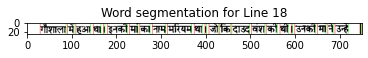

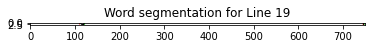

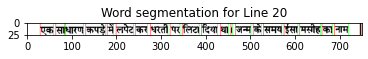

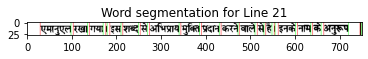

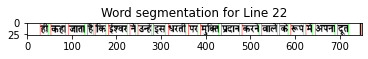

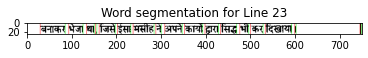

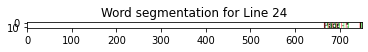

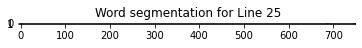

In [0]:
total_lefts = []

total_rights = []

#same code as line segmentation but applied to isolated lines rotate by 90˚
for i in range(len(uppers)):
  line_img = cv.rotate(rfinal_image[uppers[i]:lowers[i]+1], cv.ROTATE_90_CLOCKWISE)


  ret4, inverse = cv.threshold(line_img, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
  pts = cv.findNonZero(inverse)
  ret = cv.minAreaRect(pts)

  rotated = inverse
  hist = cv.reduce(inverse,1, cv.REDUCE_AVG).reshape(-1)

  th = 2
  H,W = inverse.shape[:2]
  lefts = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
  rights = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

  inverse = cv.cvtColor(rotated, cv.COLOR_GRAY2BGR)
  ret5, word = cv.threshold(inverse, 127, 255, cv.THRESH_BINARY_INV)
  for y in lefts:
      cv.line(word, (0,y), (W, y), (255,0,0), 1)

  for y in rights:
      cv.line(word, (0,y), (W, y), (0,255,0), 1)


  total_lefts.append(lefts) #replaces the dictionary structure for simpler complexity
  total_rights.append(rights)
  plt.imshow(cv.rotate(word, cv.ROTATE_90_COUNTERCLOCKWISE), 'gray')
  plt.title("Word segmentation for Line {}".format(i))
  plt.show()

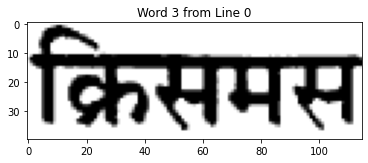

In [0]:
plt.imshow(rfinal_image[uppers[0]:lowers[0]+1,total_lefts[0][3]:total_rights[0][3]+1],'gray')
plt.title("Word 3 from Line 0")
plt.show()

In [0]:
#store rfinal_image variable for reconstruction

reseg_img = rfinal_image

###Character Segmentation

First, we remove the header line, run the same segmentation algorithm and then put back the header. 

In [0]:
def remove_one_pixel(img):
#pixel removing function

#removes a column of pixels on the left so that black line is detected!
  copy_img = np.array([np.zeros(len(img[0])-1)]*len(img))
  #print(copy_img)
  counter = 0
  for col in img:
    col_list = list(col[:len(col)-1])
    copy_img[counter] = np.array(col_list)
    counter += 1
  return copy_img

def black_pixel_counter(img, threshold):
  #return thresholded black pixel count and the row in which it occursof the image
  #since this is used to remove the header line, we only check in the top half of the image
  res = []
  col_counts = []
  print(len(img[0]),len(img))
  for i in range(len(img[0])):
    col_count = 0
    for j in range(len(img)):
      col_count += (img[j,i]/255) #127:
       # black_count +=1
    col_counts.append(col_count)
    if (col_count) <= threshold:
      res.append(i)
  print(col_counts)
  return res

#black_pixel_counter(rfinal_image[uppers[4]:lowers[4]+1,total_lefts[4][3]:total_rights[4][3]+1], 0.65)

In [0]:
for i in range(len(uppers)):
  for j in range(len(total_lefts[i])):
    gray = rfinal_image[uppers[i]:lowers[i]+1,total_lefts[i][j]:total_rights[i][j]+1]
    plt.imshow(gray,'gray')
    plt.show()
    kernel = np.zeros((5,5),np.uint8)
    erosion = cv.erode(gray,kernel,iterations = 1)
    gray_u8 = remove_one_pixel(gray).astype(np.uint8)
    plt.imshow(gray_u8,'gray')
    plt.show()
    thresh = cv.threshold(gray_u8, 127, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    
    
    
    #detect max black pixek row
    cols = black_pixel_counter(thresh,5)
    print(cols)
    if cols != []:
      for col in cols:
        for row in range(len(gray)):
        #for col in cols:
          gray[row,col] = 255
    
    # Remove horizontal
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (25,1))
    detected_lines = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv.findContours(detected_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv.drawContours(rfinal_image[uppers[i]:lowers[i]+1,total_lefts[i][j]:total_rights[i][j]+1], [c], -1, (255,255,255), 2)

    plt.imshow(rfinal_image[uppers[i]:lowers[i]+1,total_lefts[i][j]:total_rights[i][j]+1],'gray')
    plt.title("Word {} from Line {}".format(j,i))
    plt.show()
    cv.waitKey()


NameError: ignored

<class 'numpy.ndarray'>


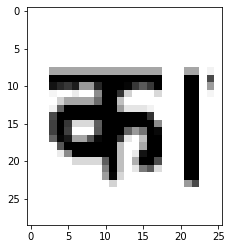

In [0]:

#pixel padding function

#adds a column of white pixels so that right character limit is found!

def add_pixel_col(img):
  copy_img = np.array([np.zeros(len(img[0])+1)]*len(img))
  #print(copy_img)
  counter = 0
  for col in img:
    col_list = list(col)
    col_list.append(255)
    copy_img[counter] = np.array(col_list)
    counter += 1
  return copy_img

i = 10
j = 3
manipulate_img = rfinal_image[uppers[i]:lowers[i]+1,total_lefts[i][j]:total_rights[i][j]+1]
      #adding padding of one pixel on the right
new = add_pixel_col(manipulate_img)
plt.imshow(new, 'gray')
print(type(new))

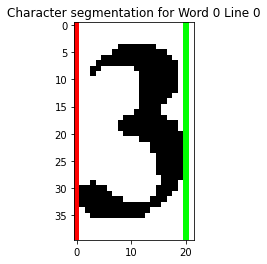

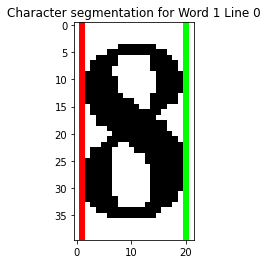

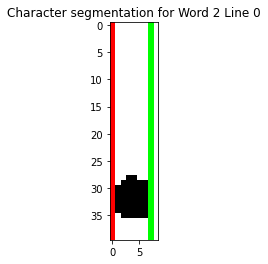

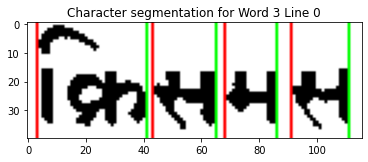

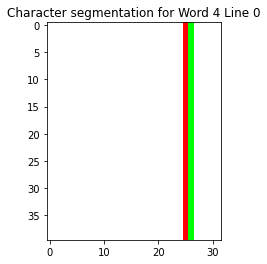

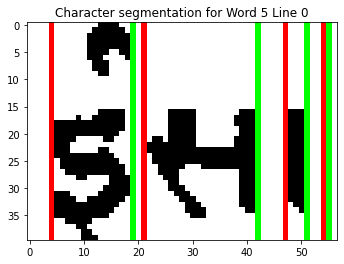

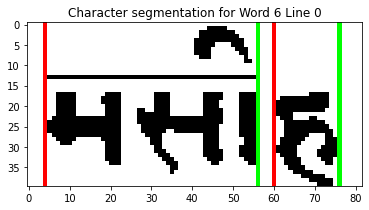

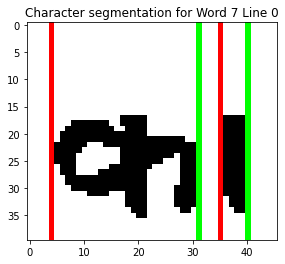

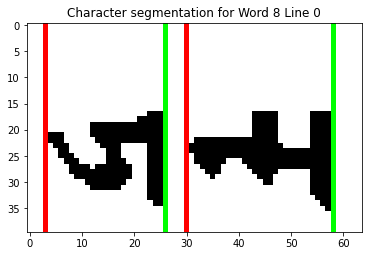

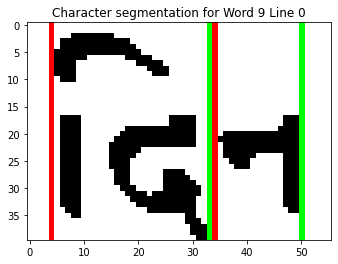

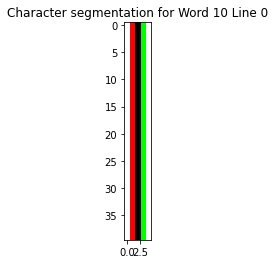

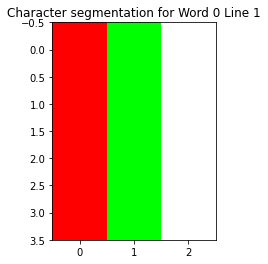

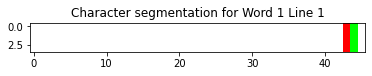

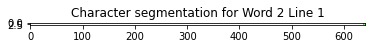

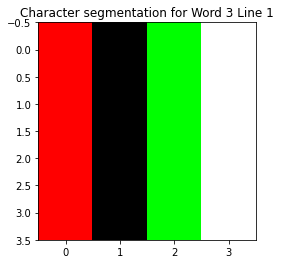

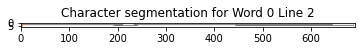

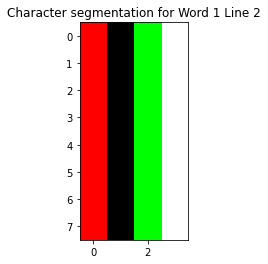

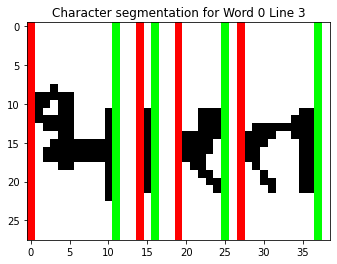

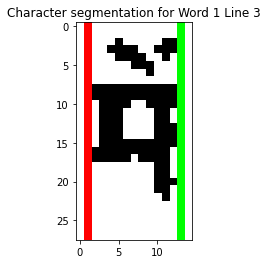

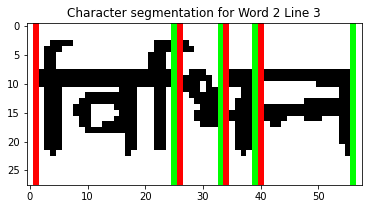

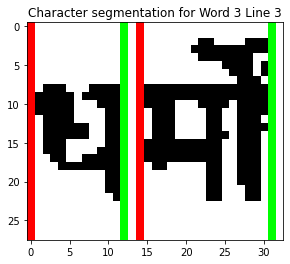

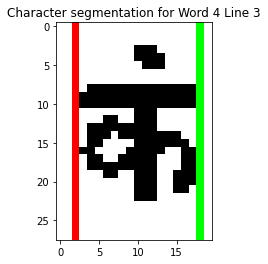

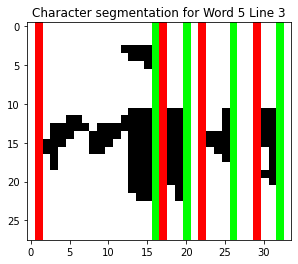

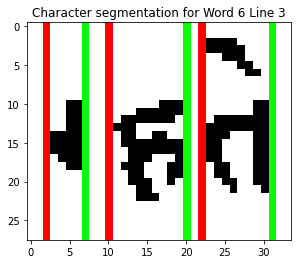

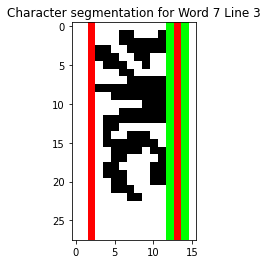

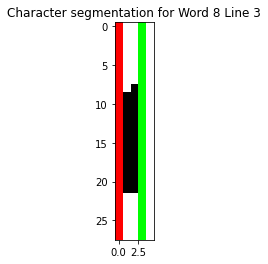

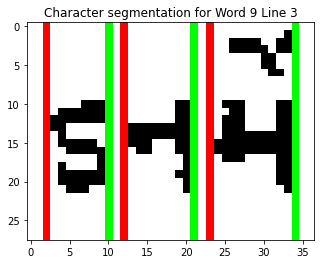

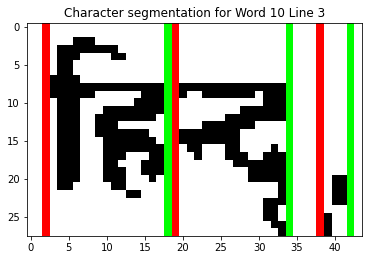

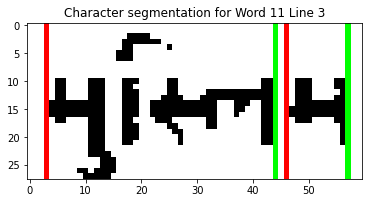

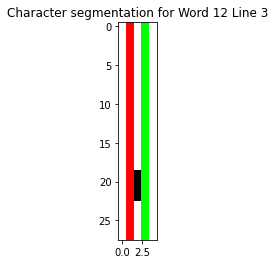

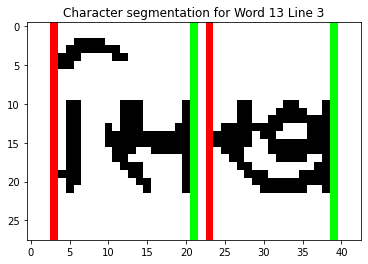

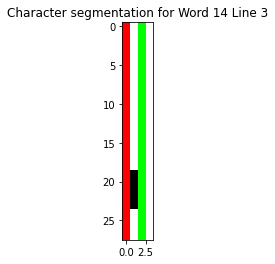

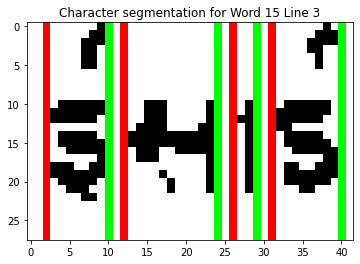

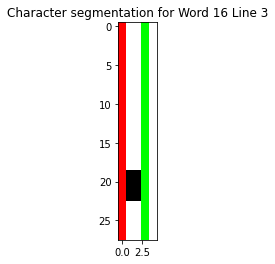

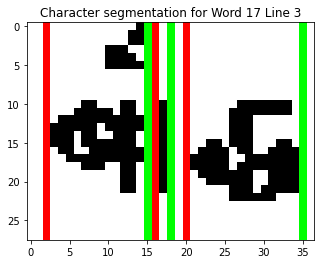

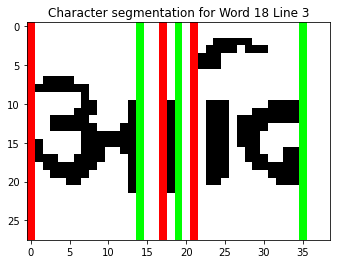

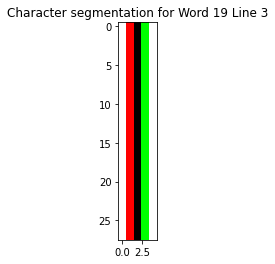

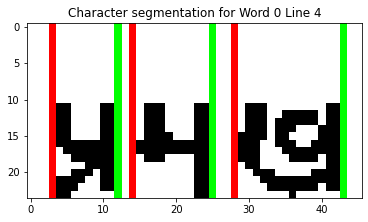

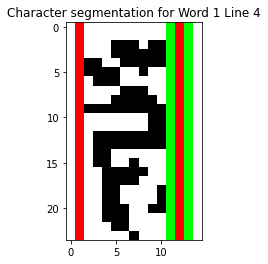

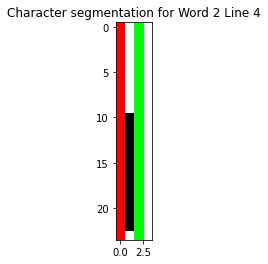

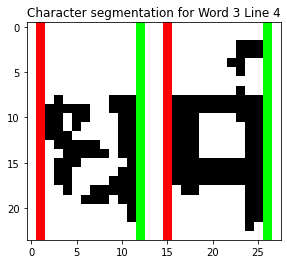

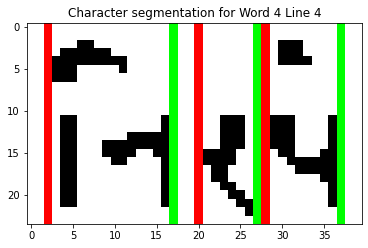

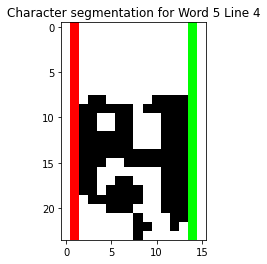

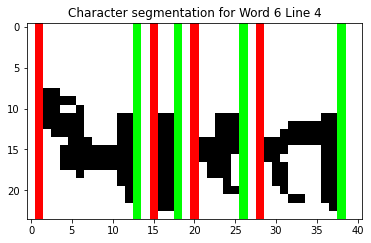

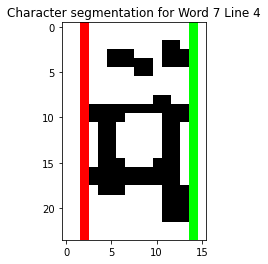

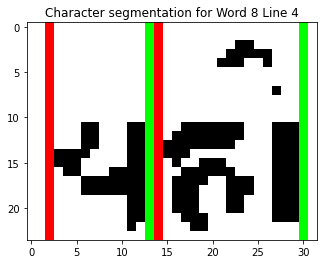

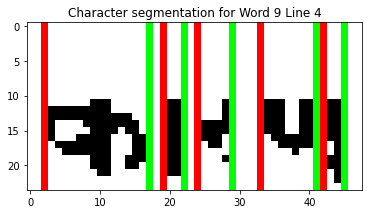

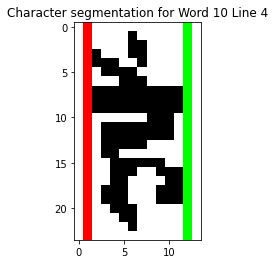

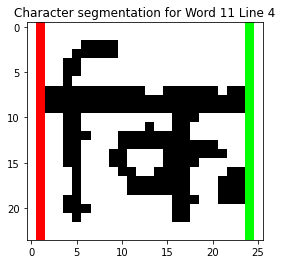

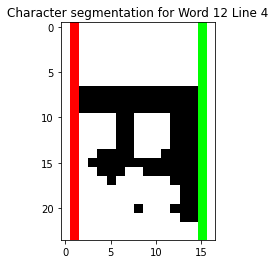

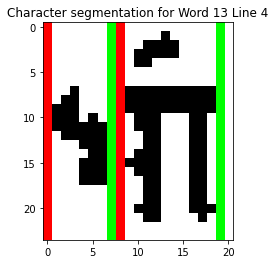

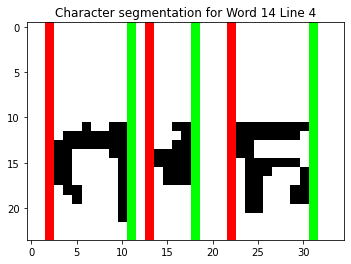

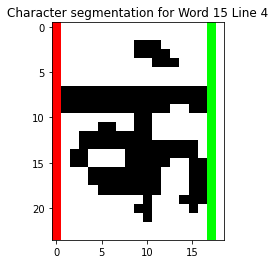

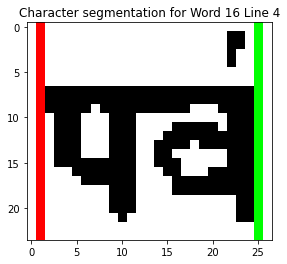

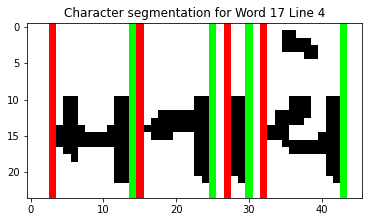

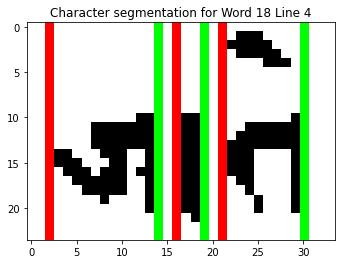

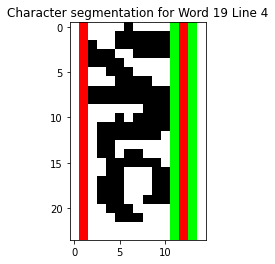

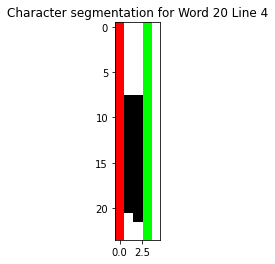

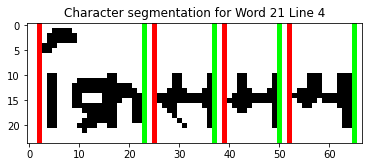

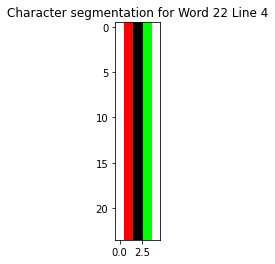

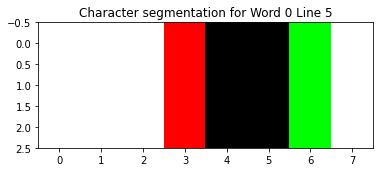

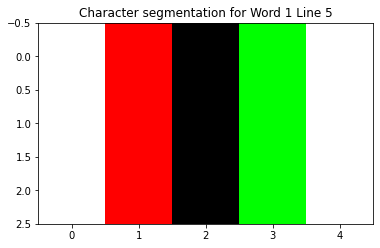

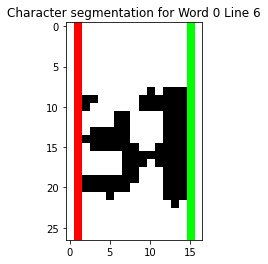

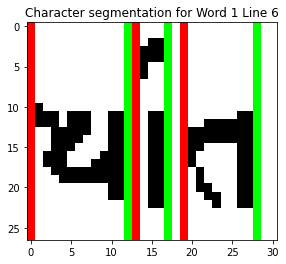

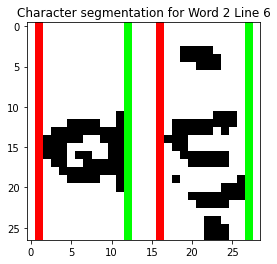

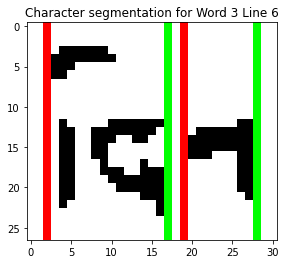

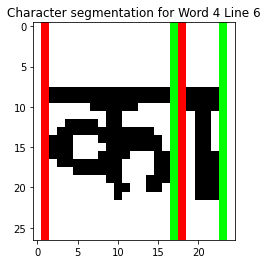

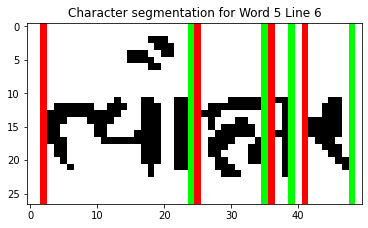

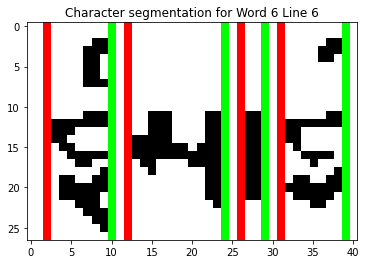

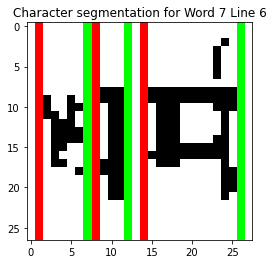

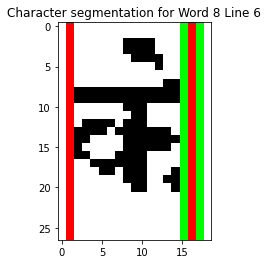

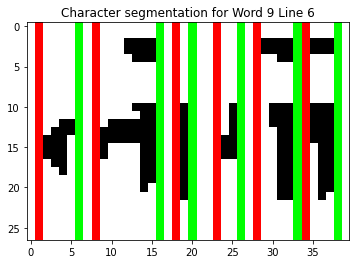

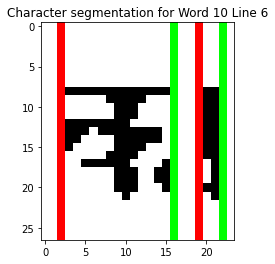

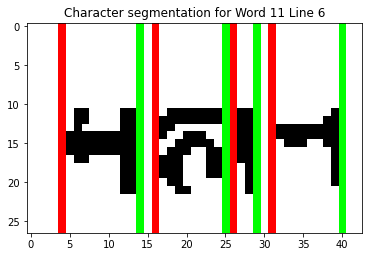

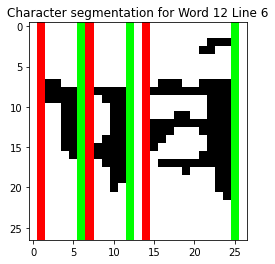

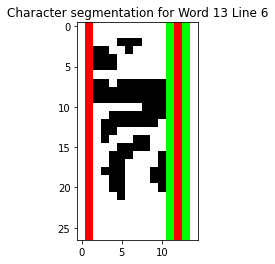

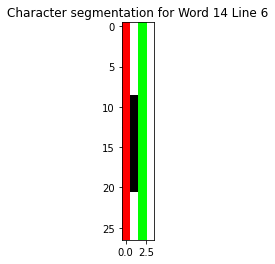

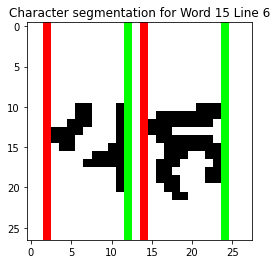

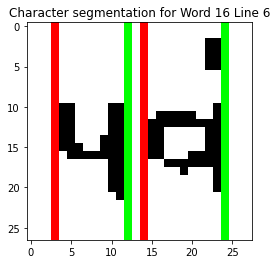

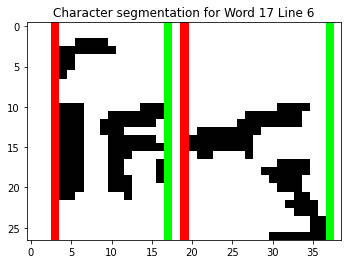

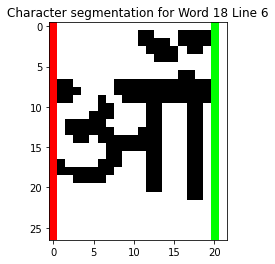

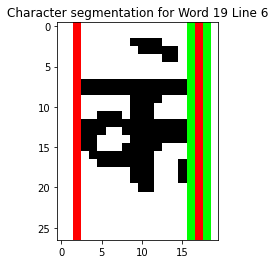

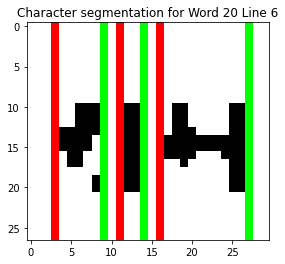

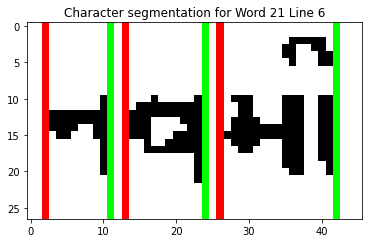

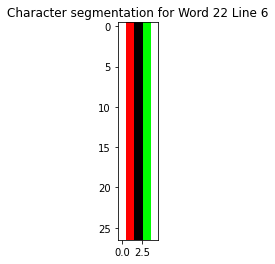

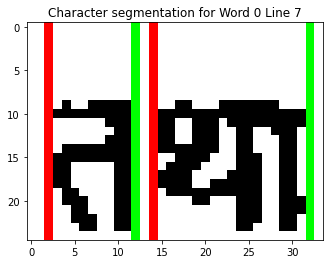

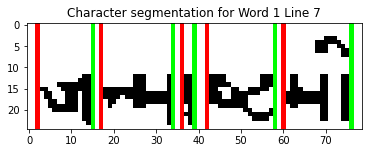

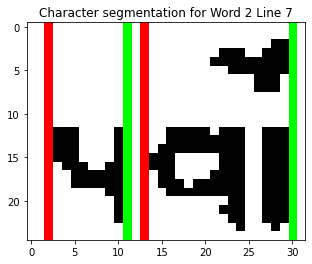

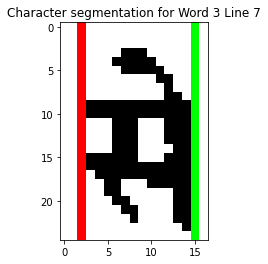

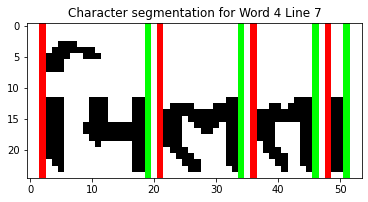

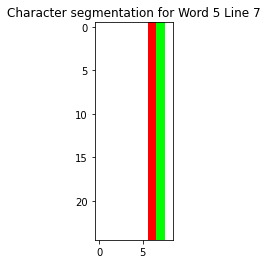

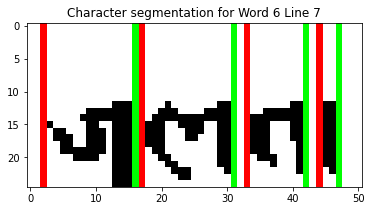

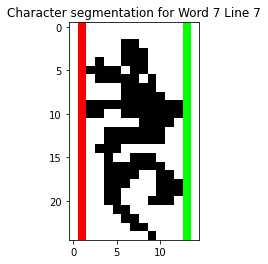

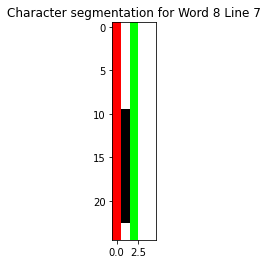

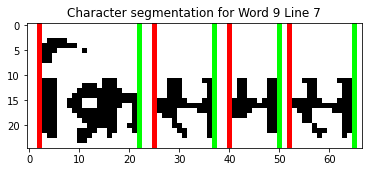

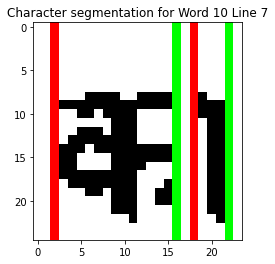

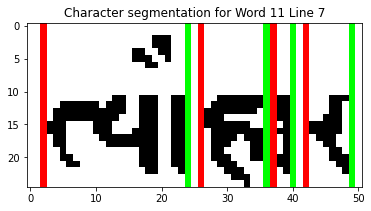

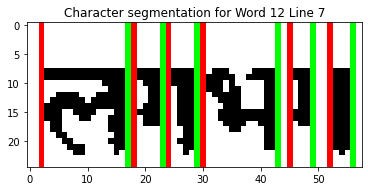

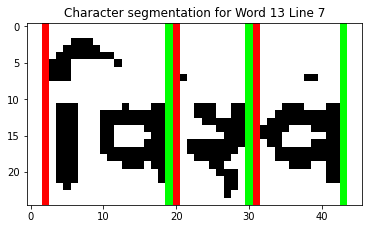

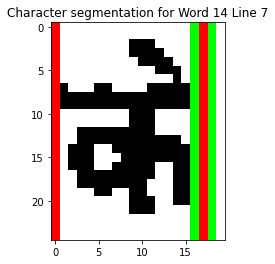

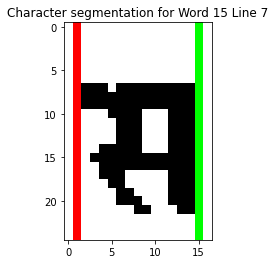

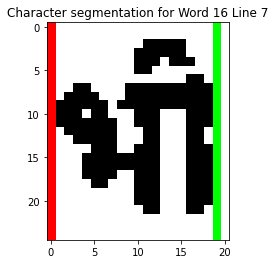

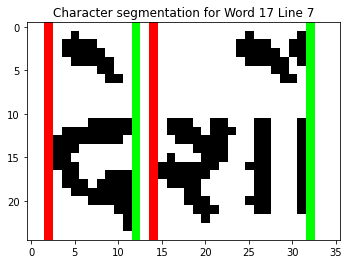

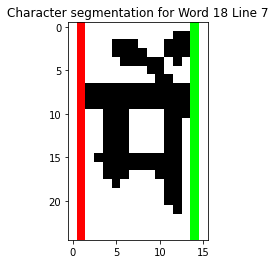

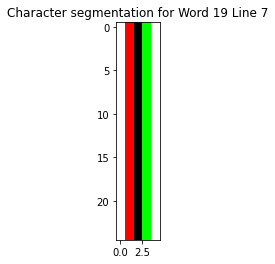

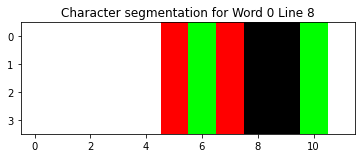

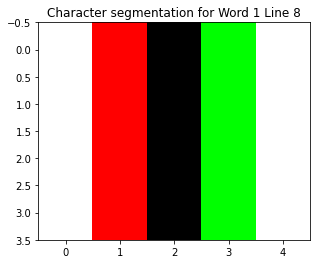

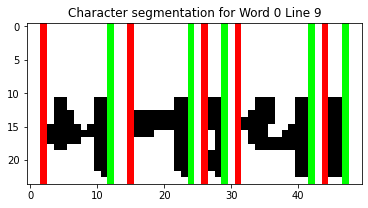

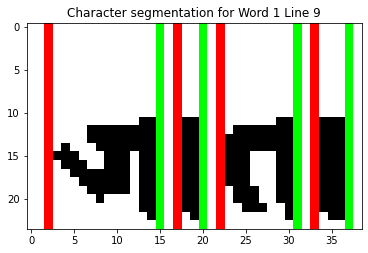

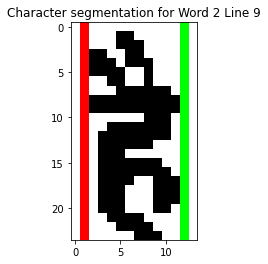

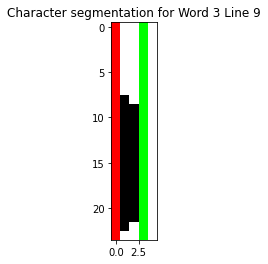

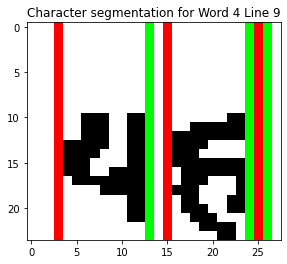

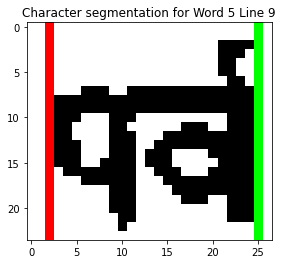

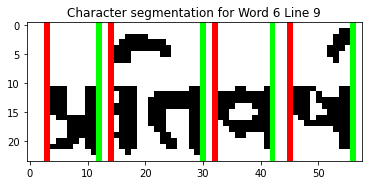

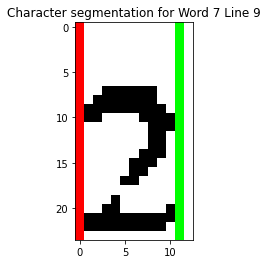

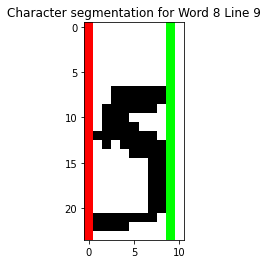

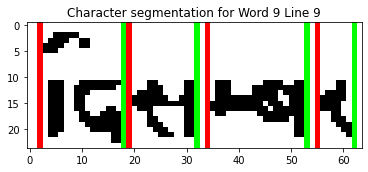

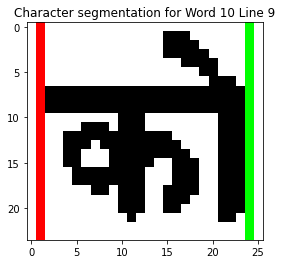

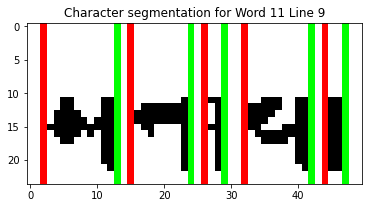

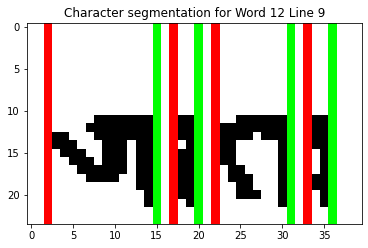

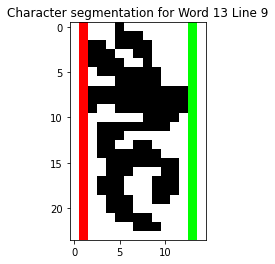

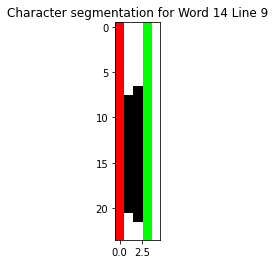

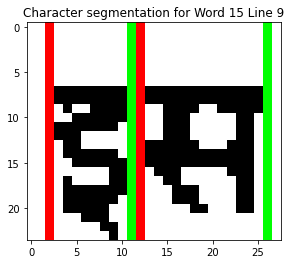

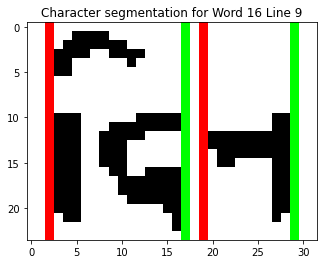

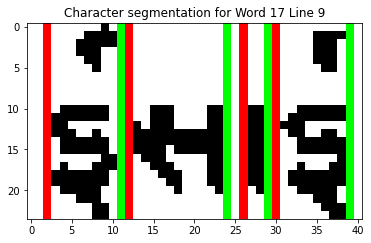

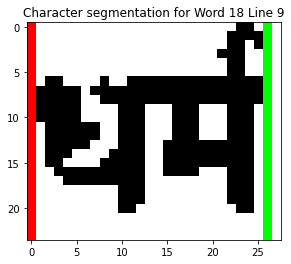

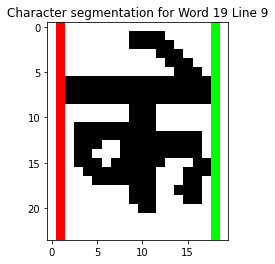

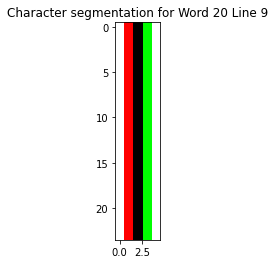

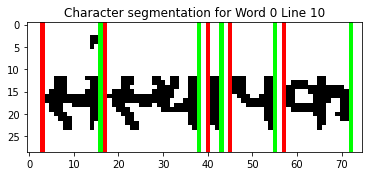

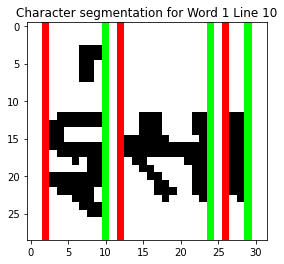

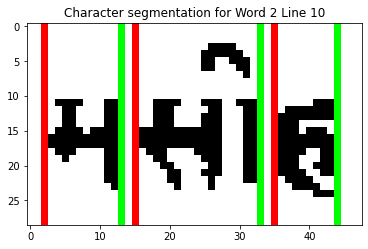

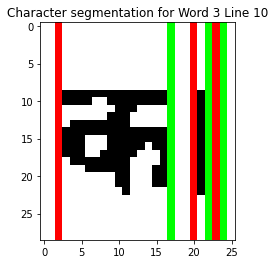

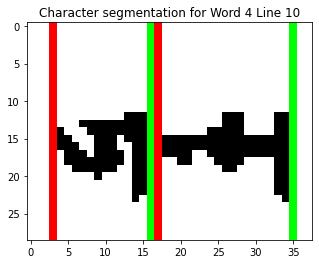

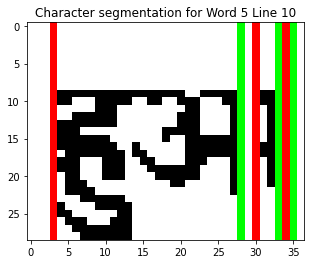

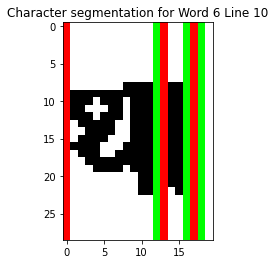

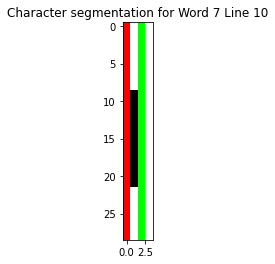

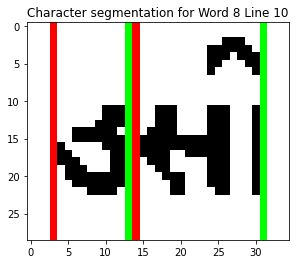

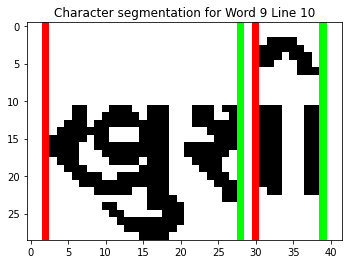

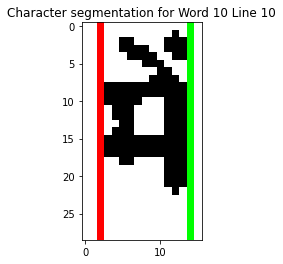

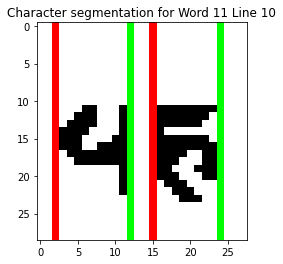

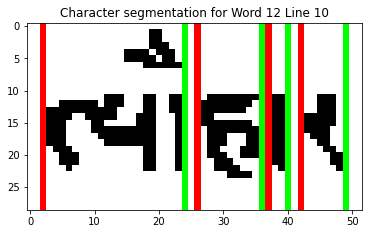

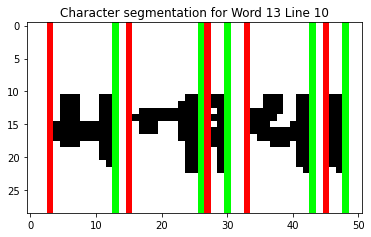

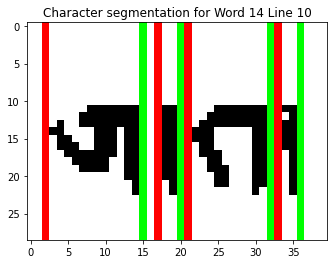

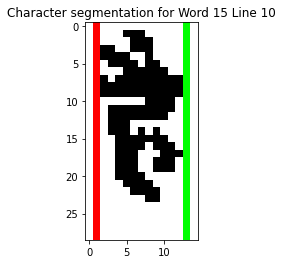

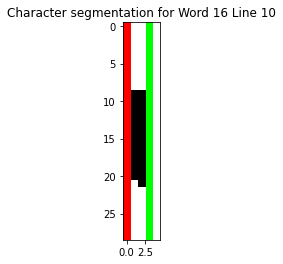

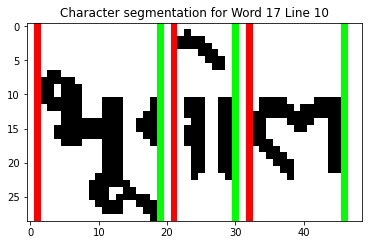

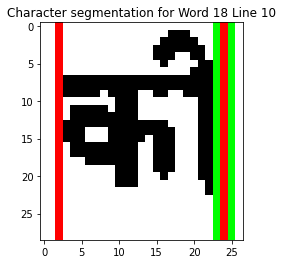

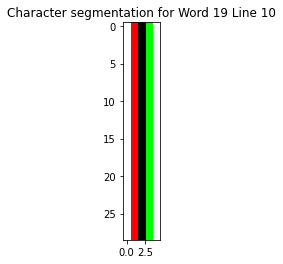

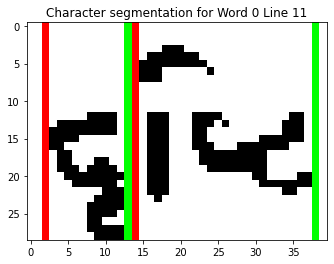

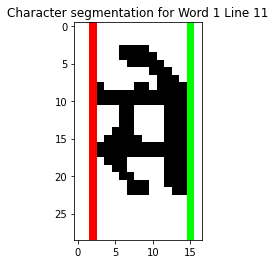

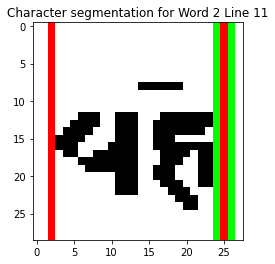

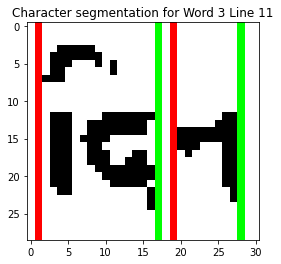

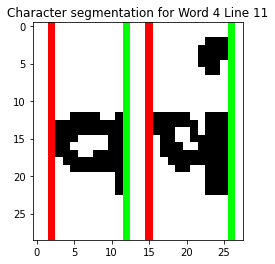

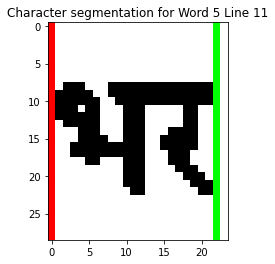

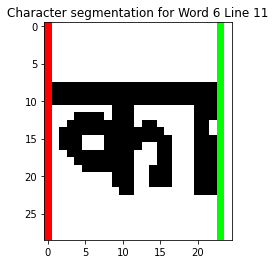

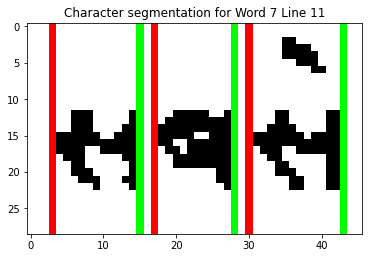

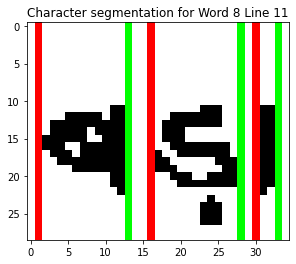

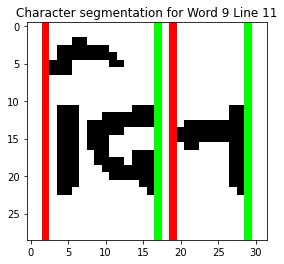

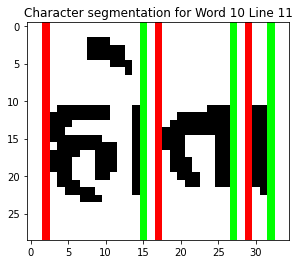

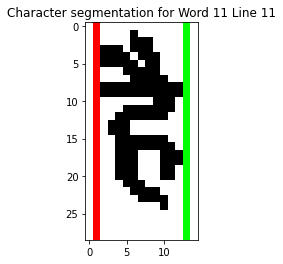

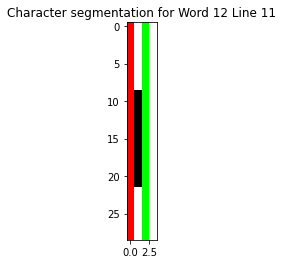

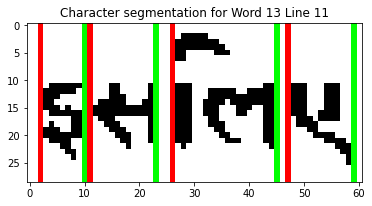

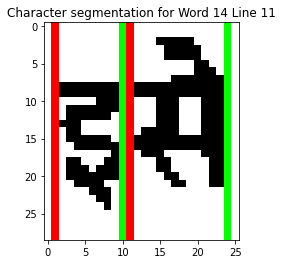

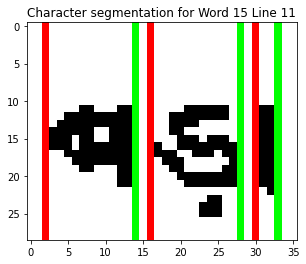

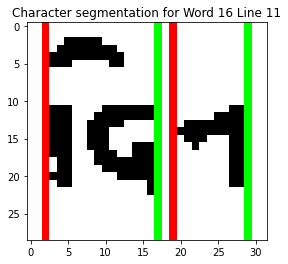

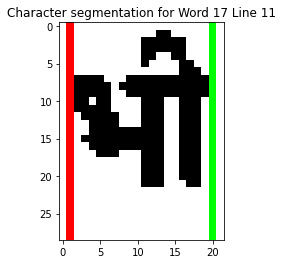

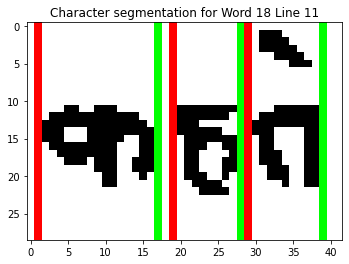

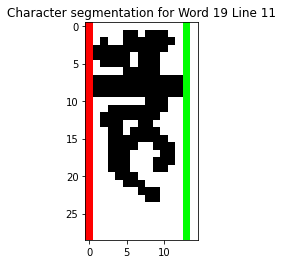

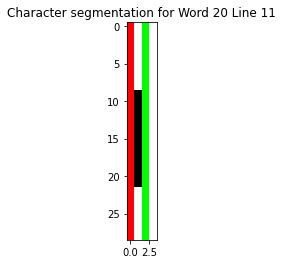

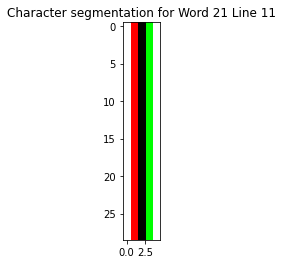

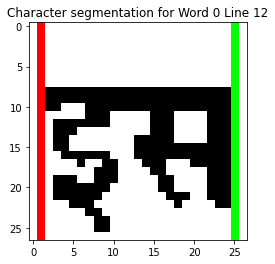

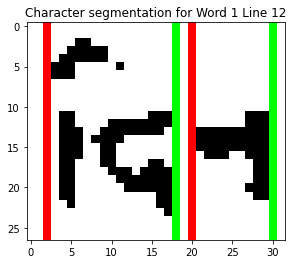

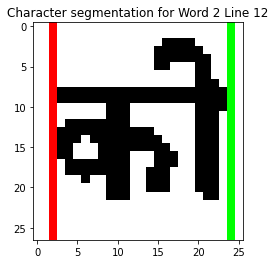

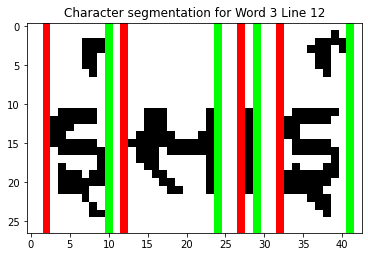

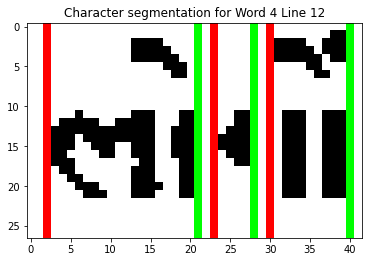

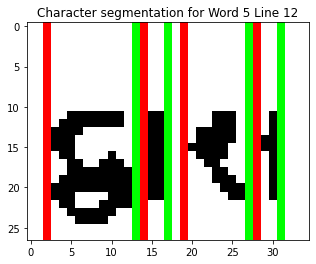

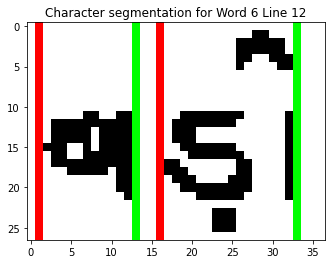

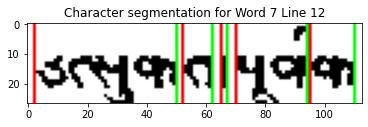

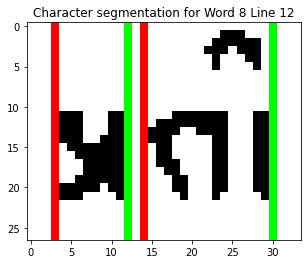

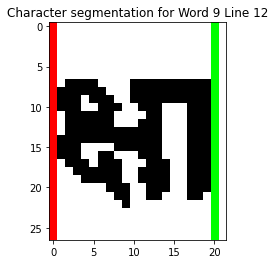

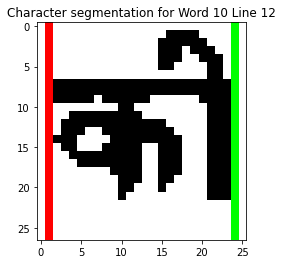

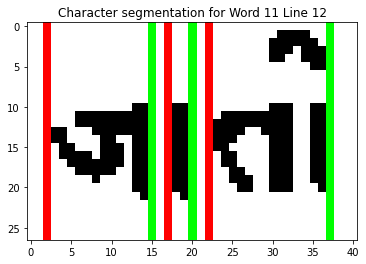

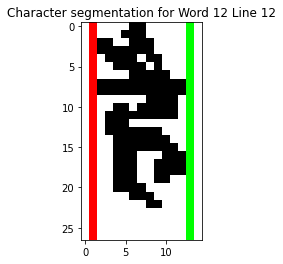

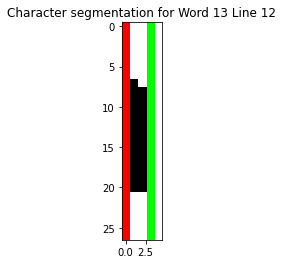

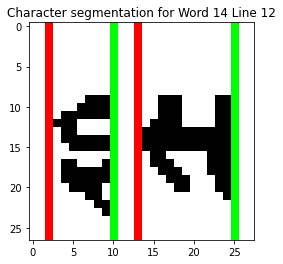

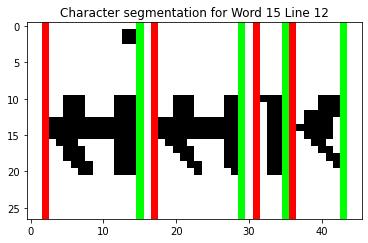

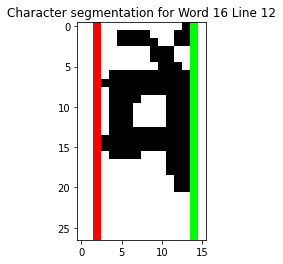

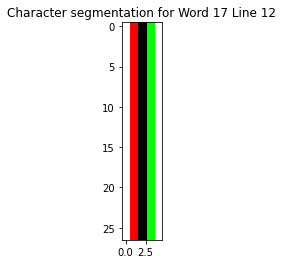

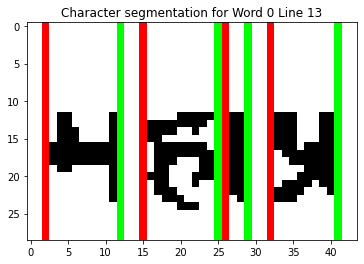

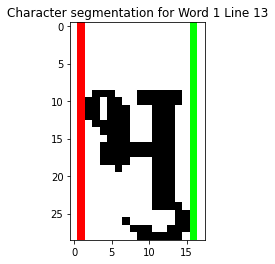

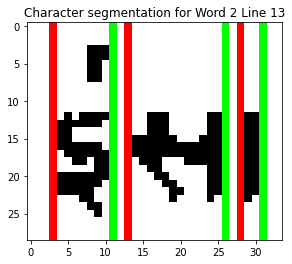

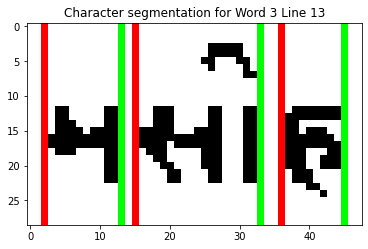

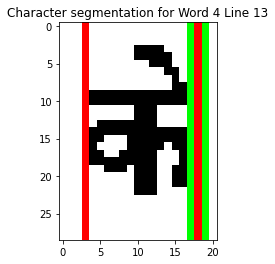

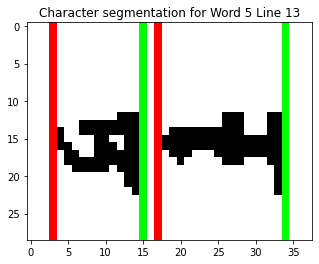

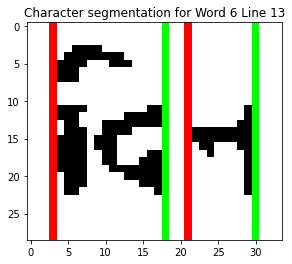

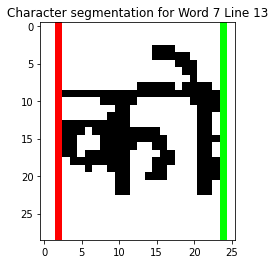

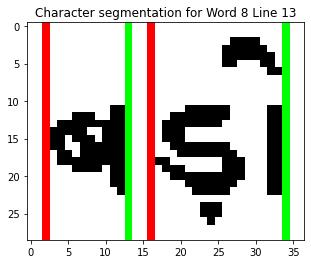

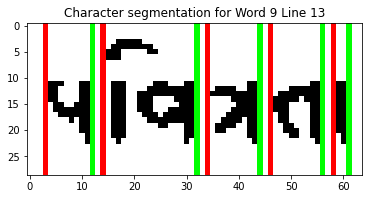

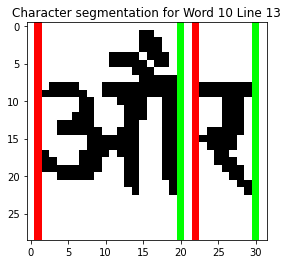

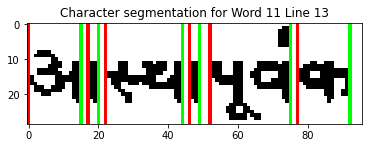

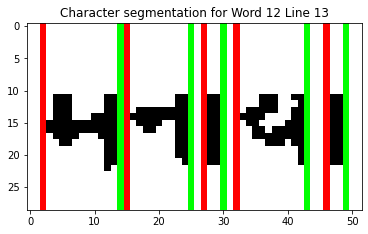

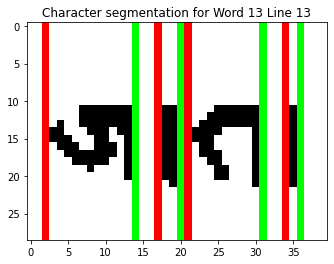

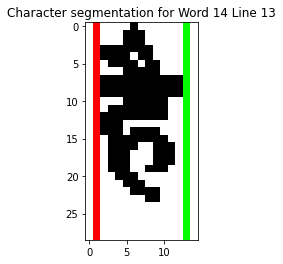

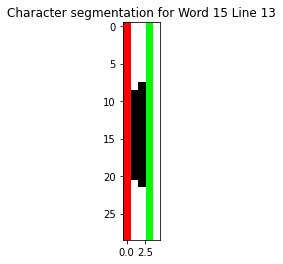

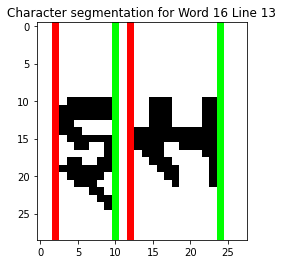

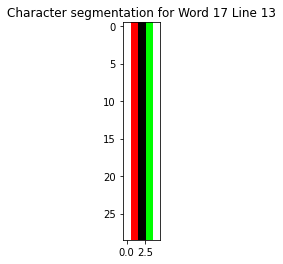

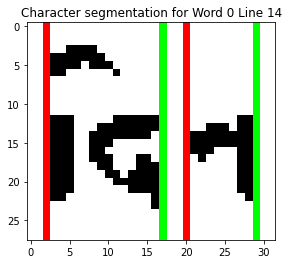

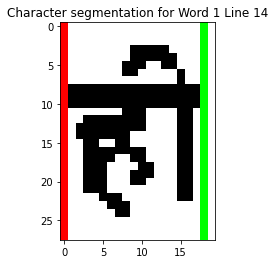

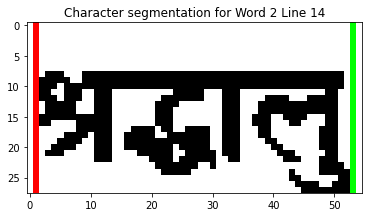

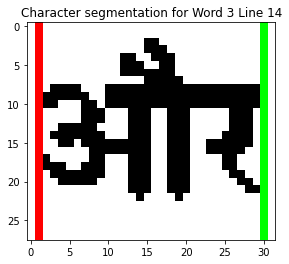

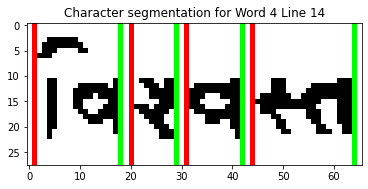

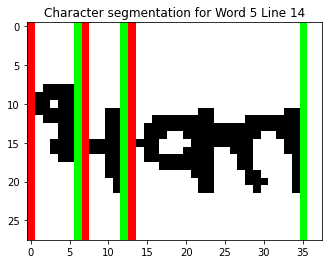

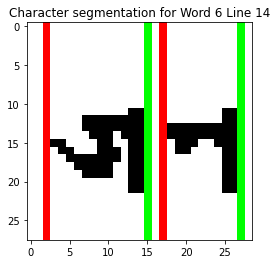

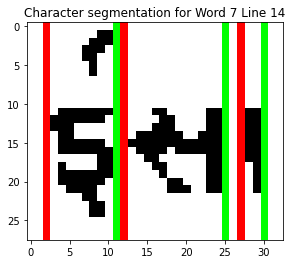

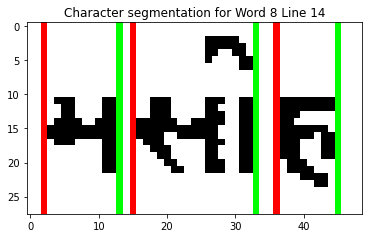

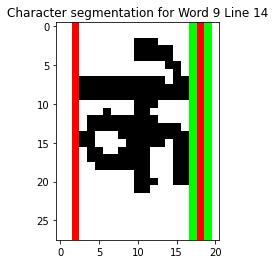

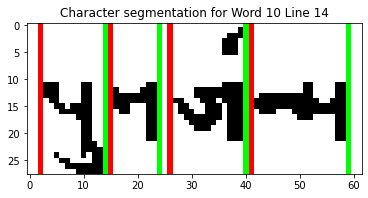

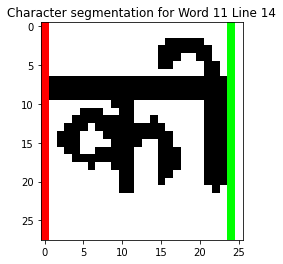

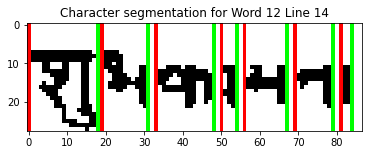

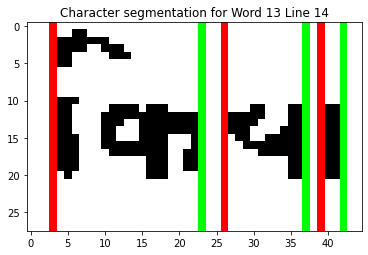

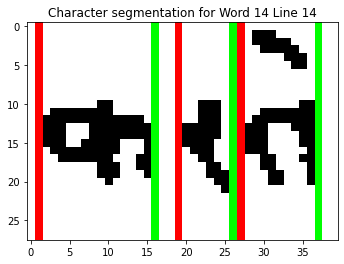

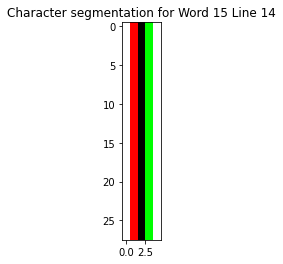

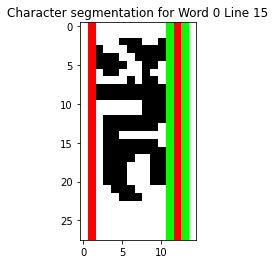

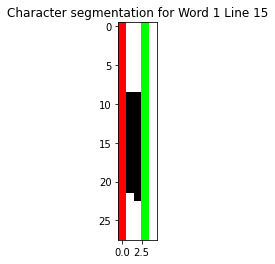

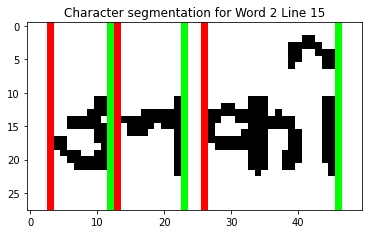

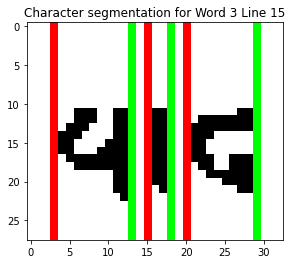

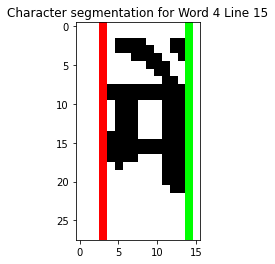

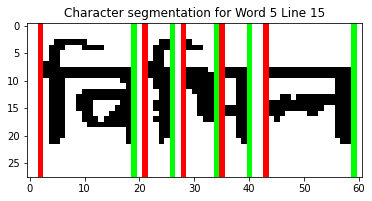

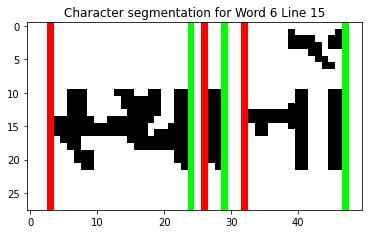

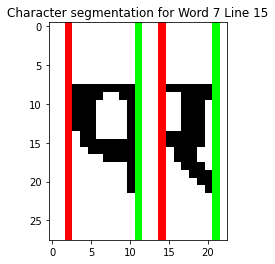

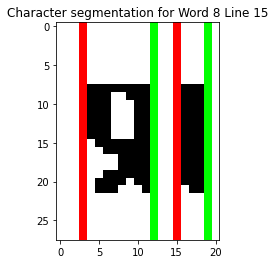

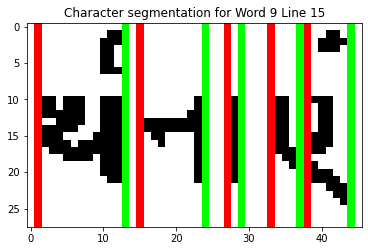

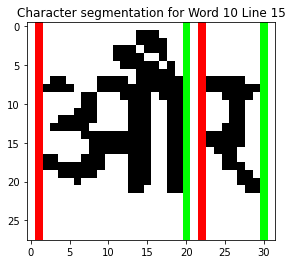

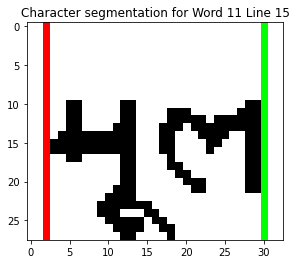

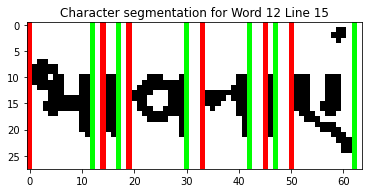

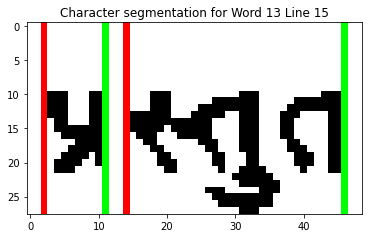

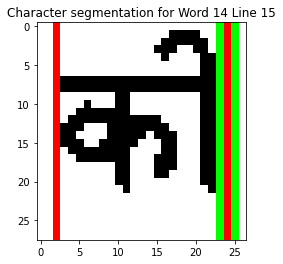

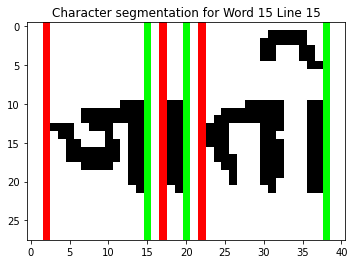

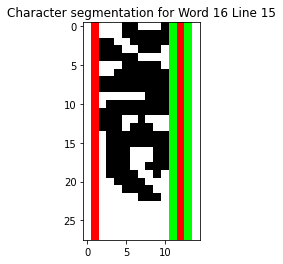

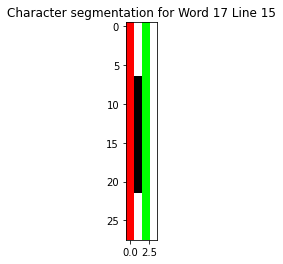

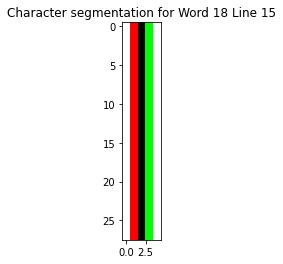

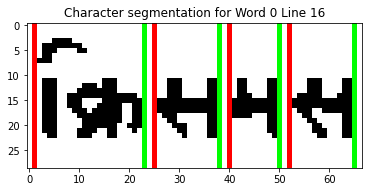

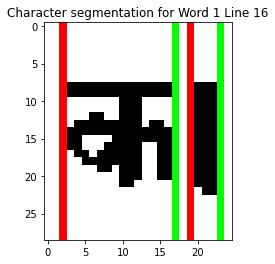

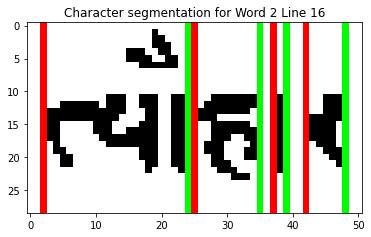

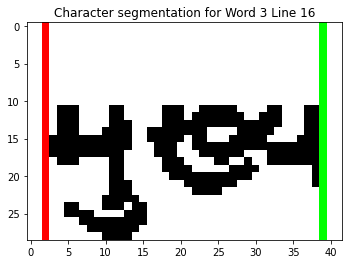

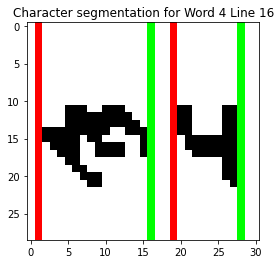

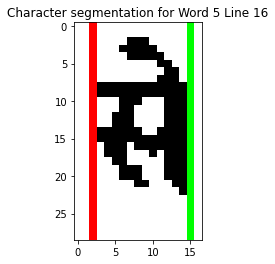

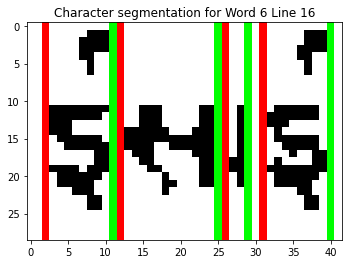

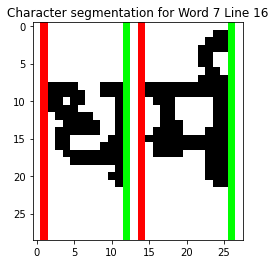

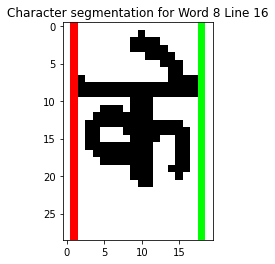

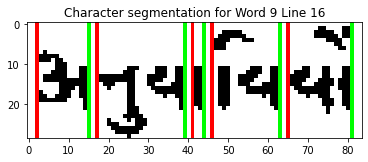

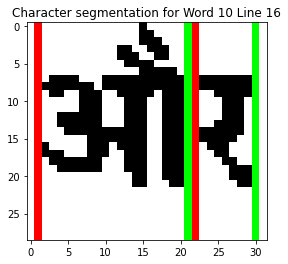

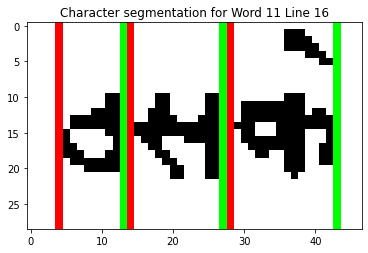

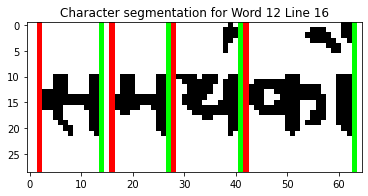

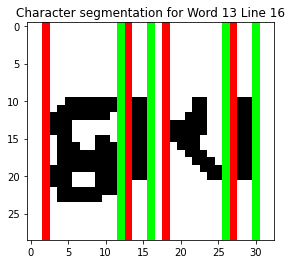

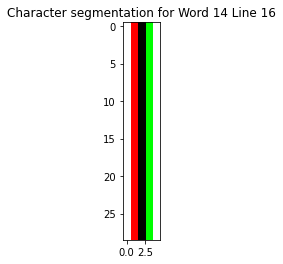

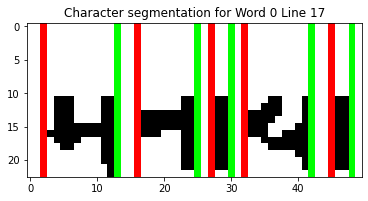

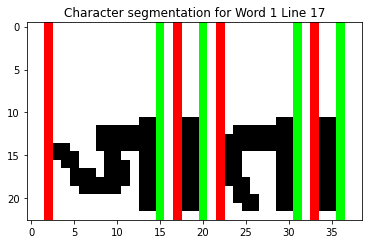

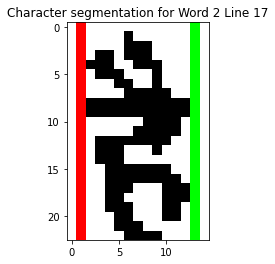

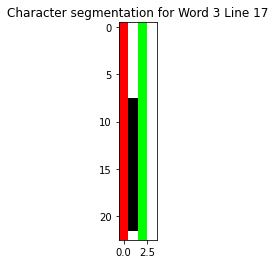

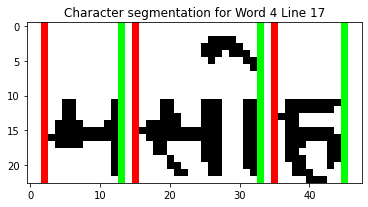

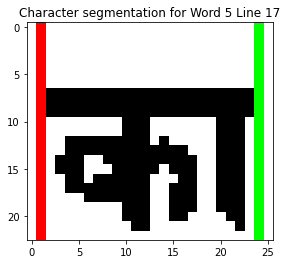

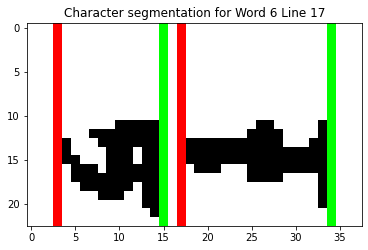

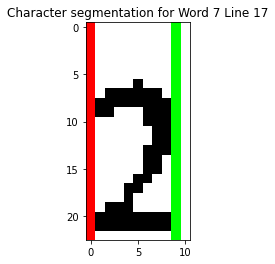

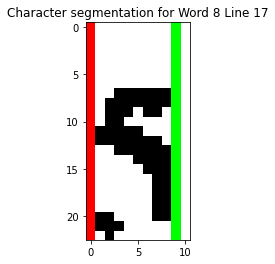

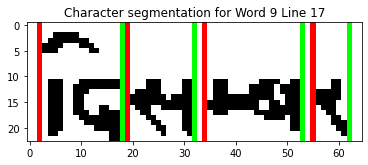

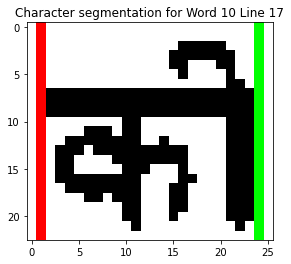

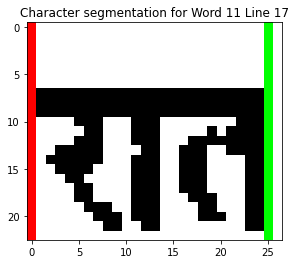

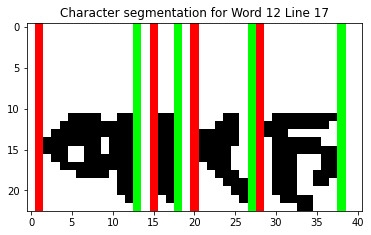

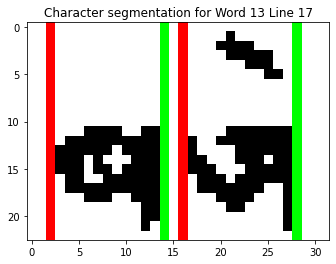

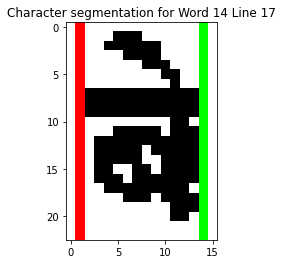

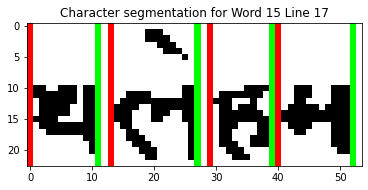

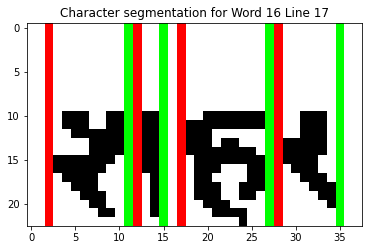

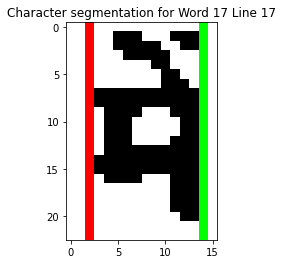

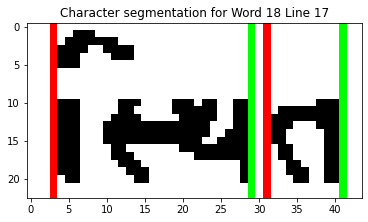

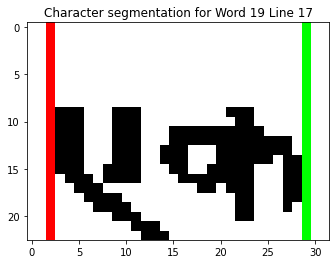

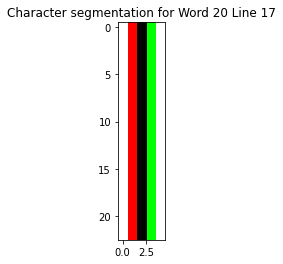

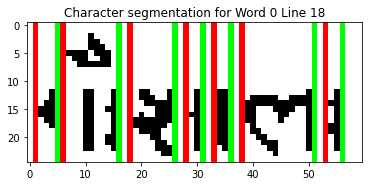

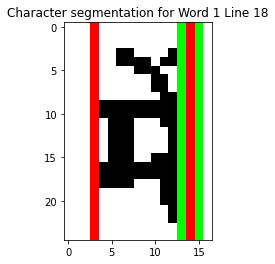

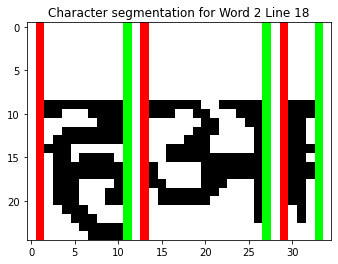

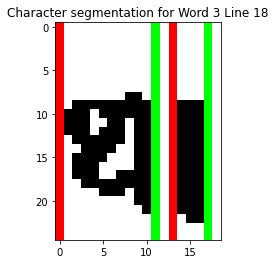

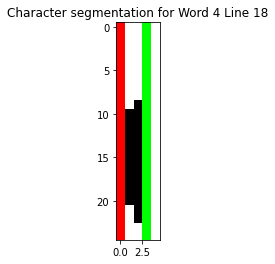

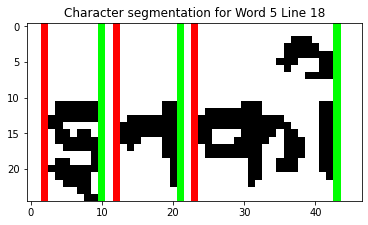

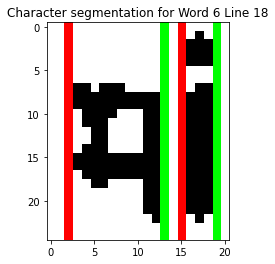

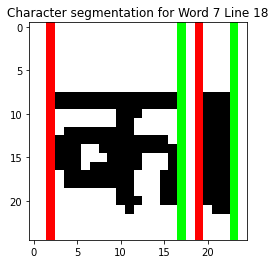

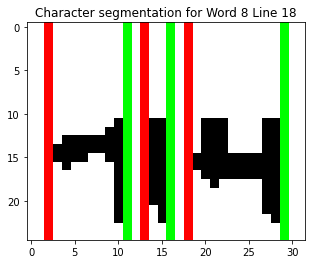

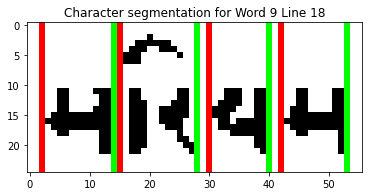

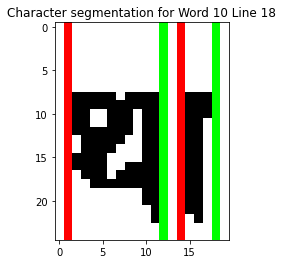

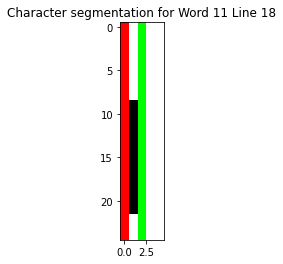

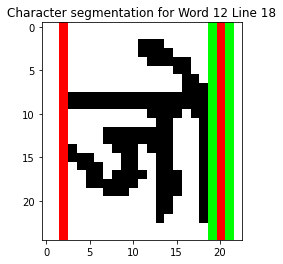

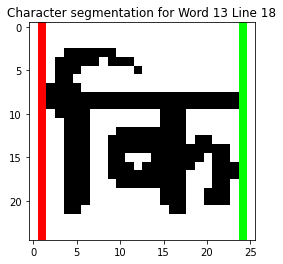

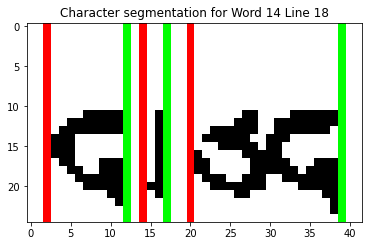

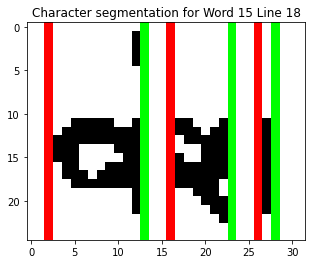

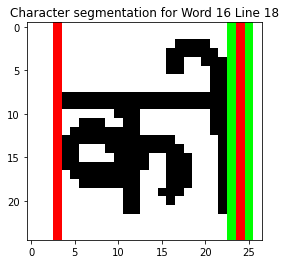

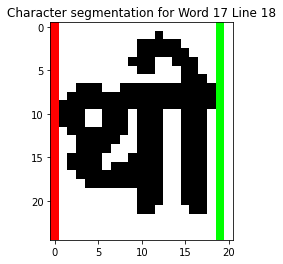

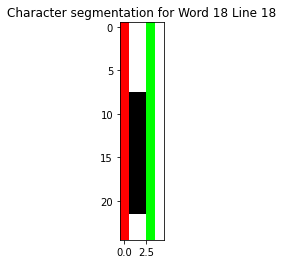

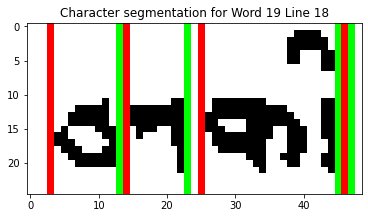

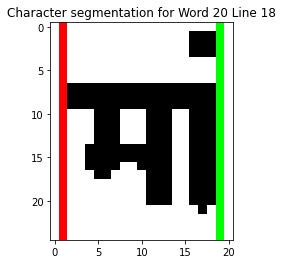

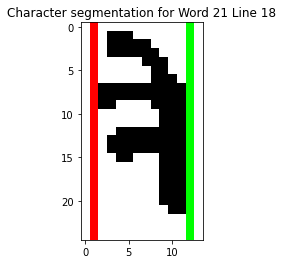

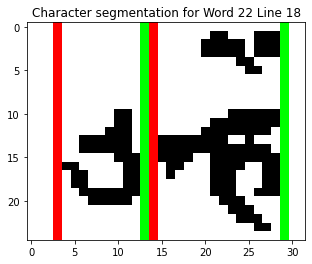

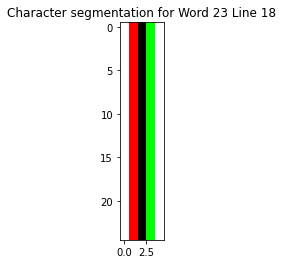

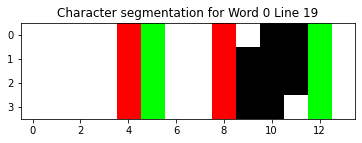

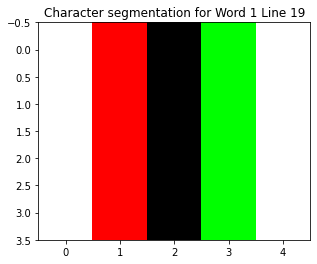

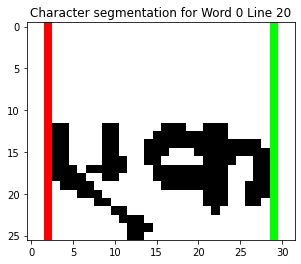

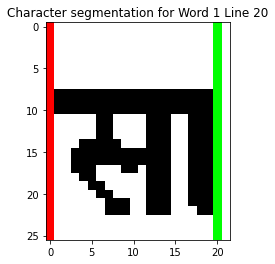

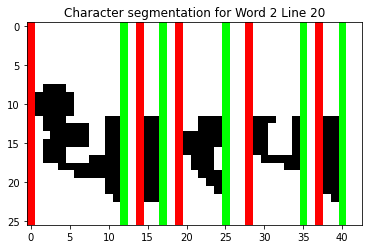

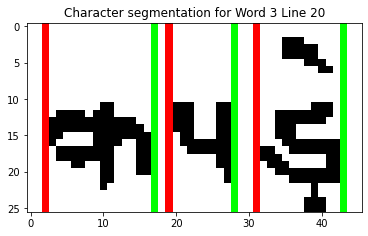

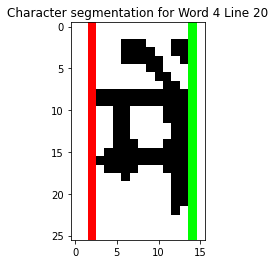

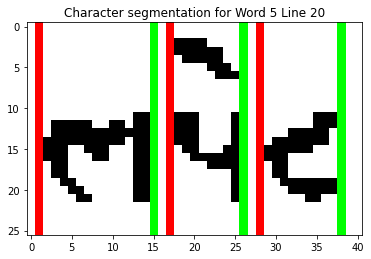

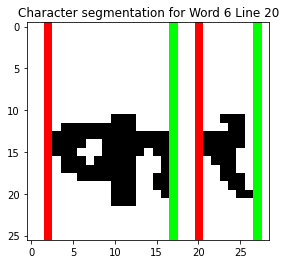

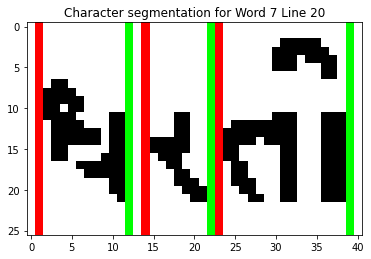

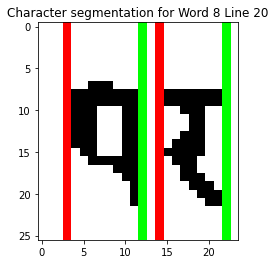

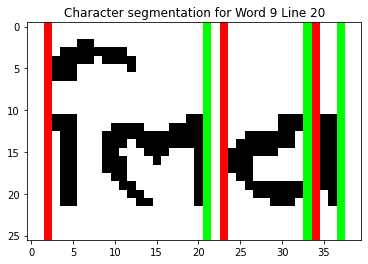

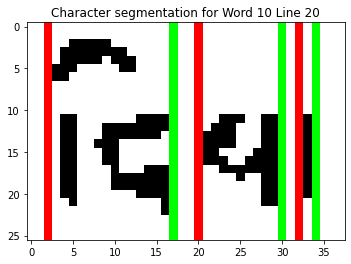

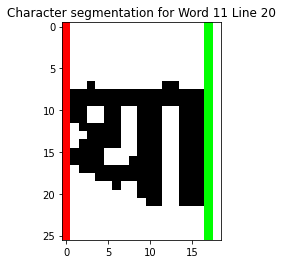

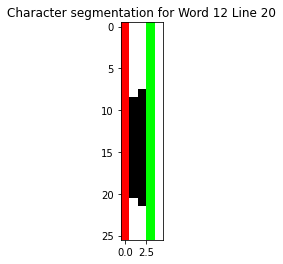

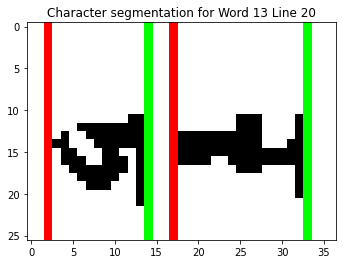

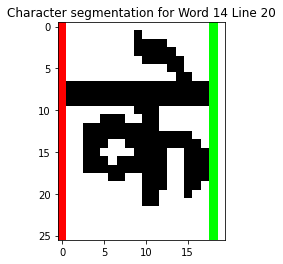

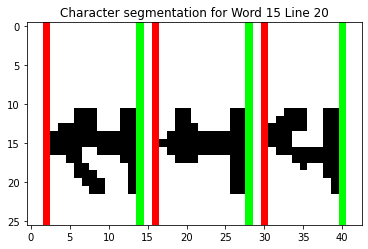

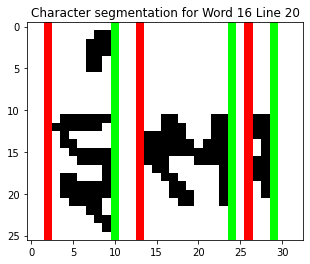

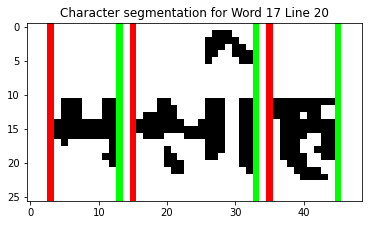

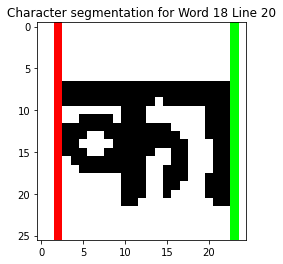

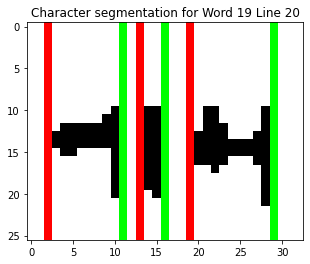

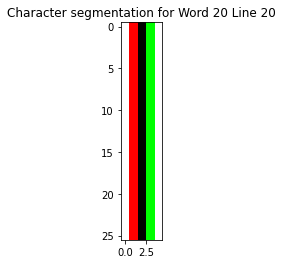

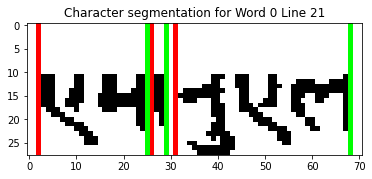

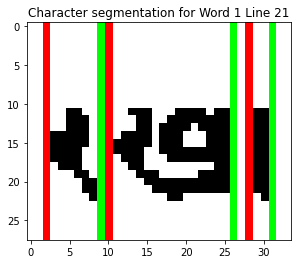

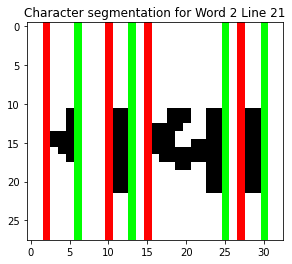

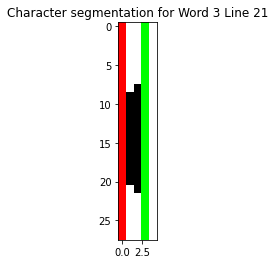

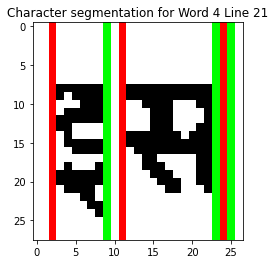

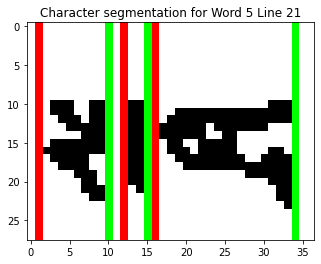

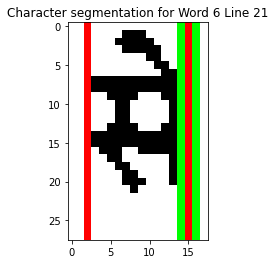

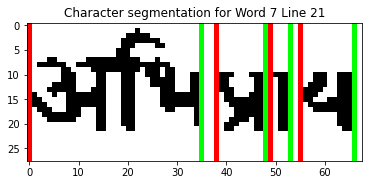

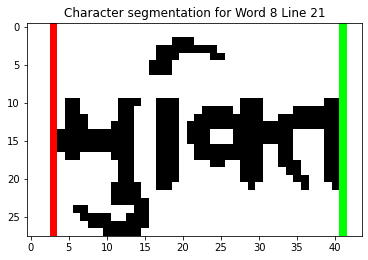

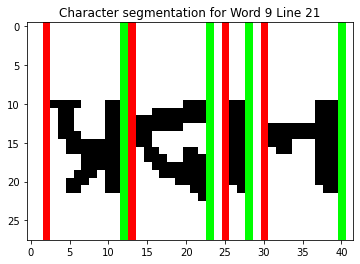

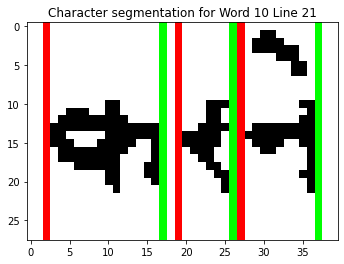

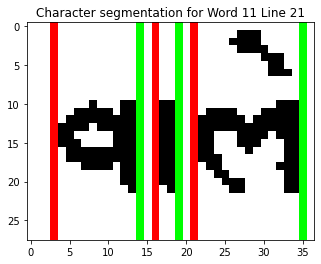

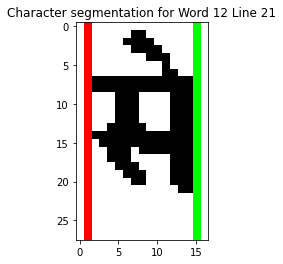

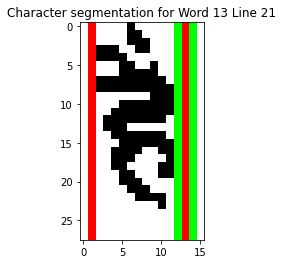

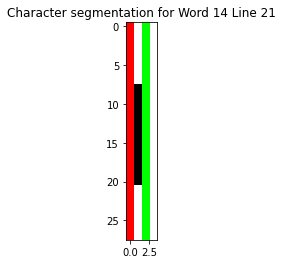

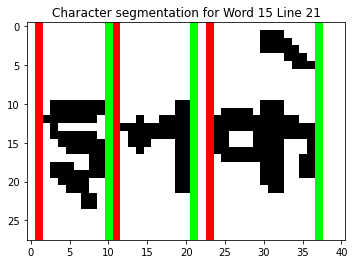

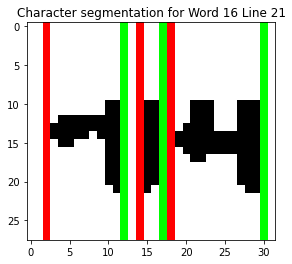

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
char_lefts = []

char_rights = []

#same code as line segmentation but applied to isolated lines rotate by 90˚
for i in range(len(uppers)):
  left = []
  right = []
  for j in range(len(total_lefts[i])):
      manipulate_img = rfinal_image[uppers[i]:lowers[i]+1,total_lefts[i][j]:total_rights[i][j]+1]
      #adding padding of one pixel on the right
      manipulate_img = add_pixel_col(manipulate_img)
      u8 = manipulate_img.astype(np.uint8)
      word_img = cv.rotate(u8, cv.ROTATE_90_CLOCKWISE)
      ret4, inverse = cv.threshold(word_img, 127, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)

      hist = cv.reduce(inverse,1, cv.REDUCE_AVG).reshape(-1)

      th = 2
      H,W = inverse.shape[:2]
      lefts = [(y) for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
      rights = [(y) for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

      rotated = inverse 
      inverse = cv.cvtColor(rotated, cv.COLOR_GRAY2BGR)
      ret5, character = cv.threshold(inverse, 127, 255, cv.THRESH_BINARY_INV)
      #plt.imshow(character)
      for y in lefts:
          cv.line(character, (0,y), (W, y), (255,0,0), 1)

      for y in rights:
          cv.line(character, (0,y), (W, y), (0,255,0), 1)

      #if rights == []:
       # rights.append(total_rights[i][j])
      left.append(lefts)
      right.append(rights)
      plt.imshow(cv.rotate(character, cv.ROTATE_90_COUNTERCLOCKWISE), 'gray')
      plt.title("Character segmentation for Word {} Line {}".format(j,i))
      plt.show()
      
  char_lefts.append(left)
  char_rights.append(right)

##Character Classification

####Character Preprocessing and Adjustments

So for the preprocessing section, almost all the work has been done already all that is left to do is to standarise all images (i.e. same input size and make them into the same format as the training data for the classification network).

Here, we build a neural network to classify characters (just like in MNIST). In order to cut down on time in getting results, the final trained model will be stored and will be used directly. 

First step: Create train and test data loaders for custom dataset.

In [0]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#transform for input
data_transform = transforms.Compose([
        transforms.Resize(size=(32, 16)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

test_transform = transforms.Compose([
           transforms.Resize(size=(32, 16)),
           transforms.Grayscale(num_output_channels=1),
           transforms.ToTensor(),
           transforms.Normalize([0.5], [0.5])
    ])
character_dataset = datasets.ImageFolder(root= data_path, transform=data_transform)
test_dataset = datasets.ImageFolder(root= test_path,
                                           transform=test_transform)
#No mini batching due to limited samples
train_loader = torch.utils.data.DataLoader(character_dataset,
                                             shuffle=True,
                                             num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                             shuffle=True,
                                             num_workers=4)

classes = test_dataset.classes

dataloaders = {'train':train_loader, 'val':test_loader}

datasetsizes = {'train': len(character_dataset), 'val': len(test_dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(datasetsizes)
print(len(classes))
print(classes)

numclasses = len(classes)

{'train': 15912, 'val': 6636}
307
['0905', '09050902', '0906', '09060903', '0907', '0908', '0909', '090A', '090F', '0910', '0913', '0914', '0915', '09150902', '09150903', '0915093F', '09150940', '09150941', '09150942', '09150947', '09150948', '0915094B', '0915094C', '0916', '0917', '0917093F', '09170940', '09170941', '09170942', '09170947', '09170948', '0917094B', '0917094C', '0918', '0918093F', '09180940', '09180941', '09180942', '09180947', '09180948', '0918094B', '0918094C', '0919', '091A', '091A0902', '091A093F', '091A0940', '091A0941', '091A0942', '091A0947', '091A0948', '091A094B', '091A094C', '091B', '091B0902', '091B093F', '091B0940', '091B0941', '091B0942', '091B0947', '091B0948', '091B094B', '091B094C', '091C', '091C0902', '091C093F', '091C0940', '091C0941', '091C0942', '091C0947', '091C0948', '091C094B', '091C094C', '091D', '091D0902', '091D093F', '091D0940', '091D0941', '091D0942', '091D0947', '091D094B', '091D094C', '091D948', '091E', '091F', '091F0902', '091F093F', '091F0

Next Step: implement ConvNet architecture as discussed in the report

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

class convnet(nn.Module):

    def __init__(self, num_classes=1000):
        super(convnet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride = 2), #stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(576, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(64),
            nn.Linear(64,num_classes),
            nn.Softmax(),
       )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1) #x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


def neuralnet(num_classes,**kwargs):
    model = convnet(**kwargs)
    return model

Training Step: Check for loss and accuracy [code adapted from TDs]

In [0]:
#saving and loading checkpoints! helper functions
import shutil
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = F"{checkpoint_dir}/checkpoint.pt"
    #path = F"/content/gdrive/My Drive/{model_save_name}" 
    torch.save(state, f_path)
    if is_best:
        best_fpath = F"{best_model_dir}/best_model.pt"
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [0]:
import time 
import copy

import numpy as np
import torch

def evaluate(model, data_loader):
    #used for train and tes loss
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))
    
    err = np.sum(y_pred != y_true) / len(y_true)
    return err


def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          # loss+= criterion(outputs, labels).item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # if total > 100:
            # break
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  # return (100.0 * correct / total, loss/total)
  return correct, loss

def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 164,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True, check_path, best_path):
  since = time.time()
  total = 0
  #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #print(device)
  net.to(device)

  #Data Analysis

  train_err = []
  test_err = []
  train_loss = []
  for epoch in range(n_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)
          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            # break
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
      is_best = False
      if epoch%5 == 0:
        checkpoint = {
                  'epoch': epoch + 1,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()
        }
        print("Saving Checkpoint!")
        save_ckp(checkpoint, is_best, chkpt_dir, best_dir)
        print("Checkpoint Saved! ")
      train_loss.append(loss.item())
      train_err.append(evaluate(net, train_loader))
      test_err.append(evaluate(net, test_loader))
      
  
  return(net, train_loss, train_err, test_err)
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best Testing Accuracy: {:4f}'.format(best_acc))

  print('Finished Training')

In [0]:
model =  neuralnet(num_classes = numclasses)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
final_net, train_loss, train_err, test_err = train(model, optimizer, trainloader, testloader, criterion, n_epoch = 100)

In [0]:
#loading checkpoints!
criterion = nn.CrossEntropyLoss()

model =  neuralnet(num_classes = 307)
optimizer = torch.optim.SGD(Anet.parameters(), lr=0.001, momentum=0.9)
ckp_path = '/content/gdrive/My Drive/Models/Checkpoints/checkpoint.pt'
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)

In [0]:
check_path = '/content/gdrive/My Drive/Models/Checkpoints'
best_path = '/content/gdrive/My Drive/Models/Best'
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
final_net1, train_loss1, train_err1, test_err1 = train(model, optimizer, trainloader, testloader, criterion, n_epoch = 100)

Streaming output truncated to the last 5000 lines.
Iteration 17552/6636: Running Loss: 11249.082233428955, Running Acc:66
Iteration 17553/6636: Running Loss: 11255.962398529053, Running Acc:66
Iteration 17554/6636: Running Loss: 11262.844596862793, Running Acc:66
Iteration 17555/6636: Running Loss: 11269.72312450409, Running Acc:66
Iteration 17556/6636: Running Loss: 11276.579150676727, Running Acc:66
Iteration 17557/6636: Running Loss: 11283.513713359833, Running Acc:66
Iteration 17558/6636: Running Loss: 11290.418540477753, Running Acc:66
Iteration 17559/6636: Running Loss: 11297.265396595001, Running Acc:66
Iteration 17560/6636: Running Loss: 11304.114368915558, Running Acc:66
Iteration 17561/6636: Running Loss: 11310.957220077515, Running Acc:66
Iteration 17562/6636: Running Loss: 11317.815142154694, Running Acc:66
Iteration 17563/6636: Running Loss: 11324.706699848175, Running Acc:66
Iteration 17564/6636: Running Loss: 11331.58522605896, Running Acc:66
Iteration 17565/6636: Runnin

Graphs!

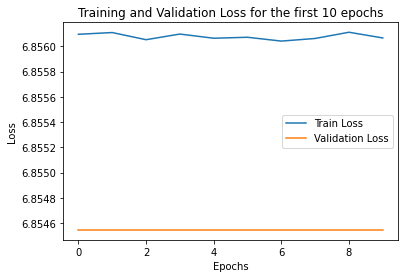

In [0]:
from matplotlib import pyplot as plt

epochs = [i for i in range(1,165)]

train_err_plot = [(1-train_err[i])*100 for i in range(len(train_err))]

test_err_plot = [(1-test_err[i])*100 for i in range(len(test_err))]

plt.axis([0, 164, 0, 100])

clr = ['r', 'g']

plt.plot(epochs, train_err_plot, f'{clr[0]}--', label = "Train Error")
plt.plot(epochs, test_err_plot, f'{clr[0]}', label = "Test Error")
plt.legend()

plt.title('Accuracy obtained by ConvNet')
plt.xlabel('Number of Epochs(1000s)')
plt.ylabel('Accuracy (%)')

In [0]:
from torchsummary import summary
summary(final_net, (1,32,32))

convnet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16)

Last step: save the model for offline classification

In [0]:
model_save_name = 'classifier.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(final_net1.state_dict(), path)

In [0]:
accuracy(final_net1, test_loader)

##Post processing

Load the Final Model

In [0]:
#loading checkpoints!
criterion = nn.CrossEntropyLoss()

model =  neuralnet(num_classes = 307)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
ckp_path = '/content/gdrive/My Drive/Models/Best/best_model.pt'
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)

In [0]:
#utf-encoder

def encoder(label):
  """
  requires label as string input
  """

  char = ''
  if len(label) == 8:
    label_1 = label[:4]
    label_2 = label[4:]
    char += chr(int(label_1,16)) + chr(int(label_2,16))
  elif len(label) == 4:
    char += chr(int(label,16))

  #final else condition handles extra characters without proper utf labels
  
  return char

Print out results

In [0]:
#text checking in console, convert to text file!
from PIL import Image 

model_v1.eval()
for i in range(6,len(uppers)):
  line = ''
  for j in range(5,len(total_lefts[i])):
    word = ''
    for k in range(len(char_lefts[i][j])): #accessing list 
      ind_1 = total_lefts[i][j] + char_lefts[i][j][k]
      ind_2 = total_lefts[i][j] + char_rights[i][j][k] + 1
      char_reg = cv.resize(final_image, dim2, interpolation = cv.INTER_AREA)
      image = char_reg[uppers[i]:lowers[i]+1,ind_1:ind_2]
      img = Image.fromarray( image , 'L') #convert to B&W PIL image, and then apply data transform.
      output = model(data_transform(img).unsqueeze_(0).cuda())
      _,prediction = torch.max(output, 1)
      prediction = int(prediction) #torch label, need to convert
      utf_encode = encoder(classes[prediction])
      word += utf_encode
      print("word: {}".format(word))

    line += word + ' '
    word += ' '
  print(line)


Show sample from Dataset

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f33ea057470>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f33ea057470>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
Traceback (most recent call last):
    w.join()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    assert self._parent_pid == 

torch.Size([80, 1, 32, 16])


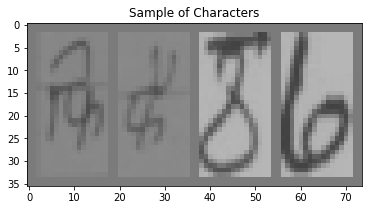

['फि', 'फै', 'ठ', '७']


In [0]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, 'gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(train_loader))
print(inputs.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])
#class_names = character_dataset.classes


imshow(out, title="Sample of Characters")


print([encoder(classes[x]) for x in labels[:4]])